<a href="https://colab.research.google.com/github/lspiteri92/RadEns/blob/main/MT_Radar_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from time import process_time

from tensorflow import keras
from keras import layers, models, initializers
from tensorboard import notebook

import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model, to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

tf.keras.backend.clear_session()

Mounted at /content/drive


In [2]:
# Load the file using h5py
with h5py.File('drive/MyDrive/Data/dataset_2.h5', 'r') as f:
    # Print the dataset names
    print(list(f.keys())) # OUT: ['iq', 'labels']

    # Get a reference to the dataset
    h5_wav_r = f['comb_wav_r']
    h5_wav_i = f['comb_wav_i']
    h5_pri = f['comb_pri']
    h5_labels_pm = f['labels_pm']
    h5_labels_pri = f['labels_pri']

    # Print the shape of the dataset
    print(h5_wav_r.shape) # OUT: (50000, 512)
    print(h5_wav_i.shape) # OUT: (50000, 512)
    print(h5_pri.shape) # OUT: (50000, 512)
    print(h5_labels_pm.shape) # OUT: (50000,)
    print(h5_labels_pri.shape) # OUT: (50000,)

    # Print the contents of the dataset
    data_r = h5_wav_r[...] # IQ data
    data_i = h5_wav_i[...] # IQ data
    data_pri = h5_pri[...] # PRI dataset
    labels_pm = h5_labels_pm[...] # Pulse modulation labels
    labels_pri = h5_labels_pri[...] # PRI modulation labels

['comb_pri', 'comb_wav_i', 'comb_wav_r', 'labels_pm', 'labels_pri']
(96000, 3000)
(96000, 3000)
(2400, 40)
(7, 96000)
(1, 2400)


In [3]:
# Combine real and complex iq into single array
data = data_r + 1j*data_i;
data.shape


(96000, 3000)

In [4]:
# Transpose data
data = data.T
labels_pm = labels_pm.T

data_pri = data_pri.T
labels_pri = labels_pri.T

print(data.shape)
print(labels_pm.shape)
print(data_pri.shape)
print(labels_pri.shape)

(3000, 96000)
(96000, 7)
(40, 2400)
(2400, 1)


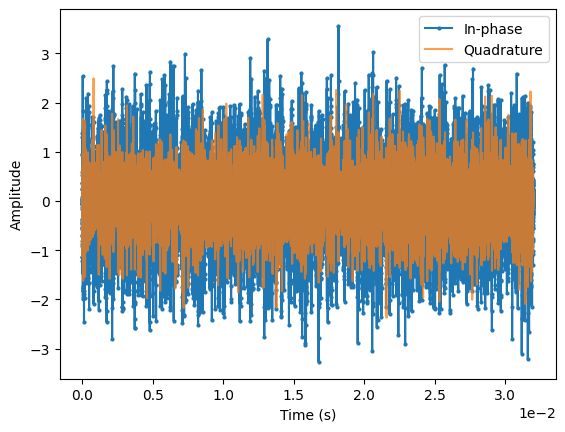

In [ ]:
# Compute time axis
sps = 3e6 # Known sampling rate
n = len(data[0])
tmax = n/sps
t = np.linspace(0, tmax, n) # Time horizon
idx = 522 # Selected radar waveform to be shown

# Create figure
fig, ax = plt.subplots()
ax.plot(t, np.real(data[idx]), marker='.', markersize=4,
        color='tab:blue', linestyle='-', linewidth=1.5,
        alpha=1, label='In-phase') # I component of the IQ signal
ax.plot(t, np.imag(data[idx]), marker='None', markersize=4,
        color='tab:orange', linestyle='-', linewidth=1.5,
        alpha=0.75, label='Quadrature') # Q component of the IQ signal

# Using scientific notation for x-axis
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
data.shape

(96000, 3000)

# 2. Data Wrangling


In [5]:
# 96,000 waveforms, each of 3000 I/Q samples

# Split each waveform into 3000 x 2 (I & Q channels)

splitIQ = data.view('(2,)float')
#splitIQ[0]
print(splitIQ.shape)

(3000, 96000, 2)


In [6]:
# reshape to have number of waveforms first
splitIQ = np.transpose(splitIQ, (1, 0, 2))
print(splitIQ.shape)

(96000, 3000, 2)


In [ ]:
dtype = ([('pm_class', '<i8'),
             ('pulse_repetition_interval', '<i8'),
             ('number_of_pulses', '<i8'),
             ('pulse_width', '<i8'),
             ('time_delay', '<i8'),
             ('sample_rate', '<i8'),
             ('signal_to_noise_ratio', '<i8')])


In [7]:
column_names = ['pm_class','pulse_repetition_interval','number_of_pulses','pulse_width','time_delay','sample_rate','signal_to_noise_ratio']
labels_pm = pd.DataFrame(labels_pm, columns=column_names)
print(labels_pm)


       pm_class  pulse_repetition_interval  number_of_pulses  pulse_width  \
0           2.0                    0.00012               3.0      0.00001   
1           3.0                    0.00012               3.0      0.00001   
2           2.0                    0.00012               3.0      0.00001   
3           2.0                    0.00012               3.0      0.00001   
4           1.0                    0.00012               3.0      0.00001   
...         ...                        ...               ...          ...   
95995       2.0                    0.00030               1.0      0.00001   
95996       1.0                    0.00012               1.0      0.00001   
95997       2.0                    0.00015               1.0      0.00001   
95998       2.0                    0.00019               1.0      0.00001   
95999       2.0                    0.00029               1.0      0.00001   

       time_delay   sample_rate  signal_to_noise_ratio  
0        0.000020 

In [ ]:
print(labels_pm[2].dtype)
print(labels_pm[2].max())
print(labels_pm[2].min())

float64
3.0
1.0


In [ ]:
print(labels_pm['pulse_repetition_interval'].dtype)
print(labels_pm['pulse_repetition_interval'].max())
print(labels_pm['pulse_repetition_interval'].min())

float64
0.00039000000000000005
7.000000000000001e-05


In [ ]:
labels_pm.iloc[1]

,1
pm_class,3.000000e+00
pulse_repetition_interval,1.200000e-04
number_of_pulses,3.000000e+00
pulse_width,1.000000e-05
time_delay,2.000000e-05
sample_rate,8.333333e+06
signal_to_noise_ratio,3.000000e+00


In [8]:
# Normalize Labels
labels_norm = labels_pm.copy()

# pm class
labels_norm['pm_class'] = labels_norm['pm_class'] - 1 # reposition to start at index 0

# num pulses
np_norm = (labels_norm['number_of_pulses'] - labels_norm['number_of_pulses'].min())/(labels_norm['number_of_pulses'].max()-labels_norm['number_of_pulses'].min())
labels_norm['number_of_pulses'] = np_norm

# pulse_width
pw_norm = (labels_norm['pulse_width'] - labels_norm['pulse_width'].min())/(labels_norm['pulse_width'].max()-labels_norm['pulse_width'].min())
labels_norm['pulse_width'] = pw_norm

# time_delay
td_norm = (labels_norm['time_delay'] - labels_norm['time_delay'].min())/(labels_norm['time_delay'].max()-labels_norm['time_delay'].min())
labels_norm['time_delay'] = td_norm

# PRI
pri_norm = (labels_norm['pulse_repetition_interval'] - labels_norm['pulse_repetition_interval'].min())/(labels_norm['pulse_repetition_interval'].max()-labels_norm['pulse_repetition_interval'].min())
labels_norm['pulse_repetition_interval'] = pri_norm

# SNR
#snr_norm = (labels_norm['signal_to_noise_ratio'] - labels_norm['signal_to_noise_ratio'].min())/(labels_norm['signal_to_noise_ratio'].max()-labels_norm['signal_to_noise_ratio'].min())
#labels_norm['signal_to_noise_ratio'] = snr_norm

print(labels_norm)

       pm_class  pulse_repetition_interval  number_of_pulses  pulse_width  \
0           1.0                    0.15625               1.0          0.0   
1           2.0                    0.15625               1.0          0.0   
2           1.0                    0.15625               1.0          0.0   
3           1.0                    0.15625               1.0          0.0   
4           0.0                    0.15625               1.0          0.0   
...         ...                        ...               ...          ...   
95995       1.0                    0.71875               0.0          0.0   
95996       0.0                    0.15625               0.0          0.0   
95997       1.0                    0.25000               0.0          0.0   
95998       1.0                    0.37500               0.0          0.0   
95999       1.0                    0.68750               0.0          0.0   

       time_delay   sample_rate  signal_to_noise_ratio  
0        0.678571 

In [ ]:
print(labels_norm['pulse_repetition_interval'].max()) ## is it correct to normalise this value?
print(labels_norm['pulse_repetition_interval'].min())

1.0
0.0


In [9]:
# 70 - 15 - 15 Train/Val/Test split per Reference

X_train, X_val, y_train, y_val = train_test_split(splitIQ,labels_norm,
                                   random_state=16,
                                   test_size=0.30,
                                   shuffle=True)

In [10]:
# standardize against training population mean & variance

train_mean = X_train.mean()
train_sigma = X_train.std()

X_train_std = (X_train - train_mean)/(train_sigma)
X_val_std = (X_val - train_mean)/(train_sigma)

# print(train_mean)

In [ ]:
# create val/test split

# X_val, X_test, y_val, y_test = train_test_split(X_val_test_std,y_val_test_split,  # was X_val_test_split
#                                    random_state=32,
#                                    test_size=0.50,
#                                    shuffle=True)

In [ ]:
print("Train Split Size:", X_train.shape)
print("Validation Split Size:", X_val.shape)
#print("Test Split Size:", X_test.shape)

Train Split Size: (67200, 3000, 2)
Validation Split Size: (28800, 3000, 2)


In [11]:
## Train Split
y_train_class = y_train['pm_class']
labels_class_train = to_categorical(y_train_class, num_classes=3)
y_train_np = y_train['number_of_pulses']
y_train_pw = y_train['pulse_width']
y_train_td = y_train['time_delay']
y_train_pri = y_train['pulse_repetition_interval']
y_train_snr = y_train['signal_to_noise_ratio']

## Validation Split
y_val_class = y_val['pm_class']
labels_class_val = to_categorical(y_val_class, num_classes=3)
y_val_np = y_val['number_of_pulses']
y_val_pw = y_val['pulse_width']
y_val_td = y_val['time_delay']
y_val_pri = y_val['pulse_repetition_interval']
y_val_snr = y_val['signal_to_noise_ratio']

## Test Split
# y_test_class = y_test['pm_class']
# labels_class_test = to_categorical(y_test_class, num_classes=3)
# y_test_np = y_test['number_of_pulses']
# y_test_pw = y_test['pulse_width']
# y_test_td = y_test['time_delay']
# y_test_pri = y_test['pulse_repetition_interval']
# y_test_snr = y_test['signal_to_noise_ratio']



In [ ]:
print(labels_class_val.shape)
print(labels_class_val.max())
print(labels_class_val.min())
(labels_class_val.sum(axis=-1) == 1).all()

(28800, 3)
1.0
0.0


True

In [ ]:
print(X_train_std.shape)
print(X_train_std[1])
X_train_std.dtype

(67200, 3000, 2)
[[-0.03957416 -0.03957416]
 [-0.03957416 -0.03957416]
 [-0.03957416 -0.03957416]
 ...
 [-1.40506622 -2.34422124]
 [ 3.52147002  1.07280146]
 [-1.15415085  0.62206088]]


dtype('float64')

# Dataset Analysis

In [10]:
labels_count = labels_pm.copy()
pri_count = labels_count['pulse_repetition_interval'].value_counts()
#pri_count_sorted = pri_count.sort_values(by='pulse_repetition_interval')

# fig = plt.figure(figsize=[20, 5])
# ax = fig.add_subplot(1, 1, 1)
# pri_count.plot(kind='bar');
# pri_count

# Define bin edges
bins = [0, 0.00005, 0.00010, 0.00015, 0.00020, 0.00025, 0.00030, 0.00035, 0.00040]  # Define edges for the bins
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30','30-35','35-40']  # Optional labels for the bins

labels_count['binned'] = pd.cut(labels_count['pulse_repetition_interval'], bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
bin_counts = labels_count['binned'].value_counts().sort_index()

# Print the counts for verification
print(bin_counts);

binned
0-5          0
5-10      2160
10-15    21580
15-20    22050
20-25    21640
25-30    19870
30-35     7690
35-40     1010
Name: count, dtype: int64


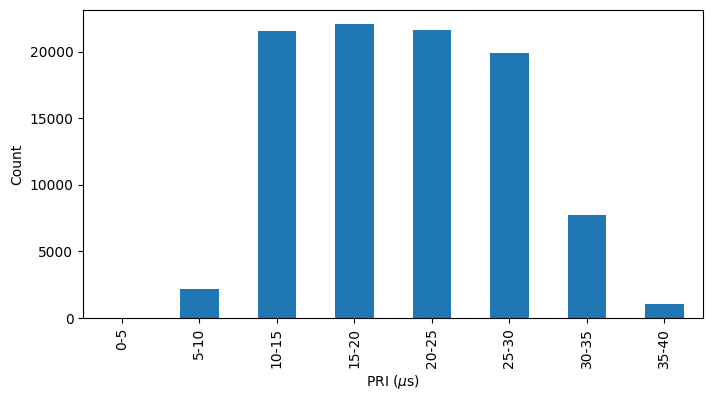

In [11]:
fig = plt.figure(figsize=[8, 4])
bin_counts.plot(kind='bar')
plt.xlabel('PRI ($\mu$s)')
plt.ylabel('Count')
plt.show()

pm_class
Constant       22417
LFM            22427
Phase Coded    22356
Name: count, dtype: int64
pm_class
Constant       9545
LFM            9622
Phase Coded    9633
Name: count, dtype: int64


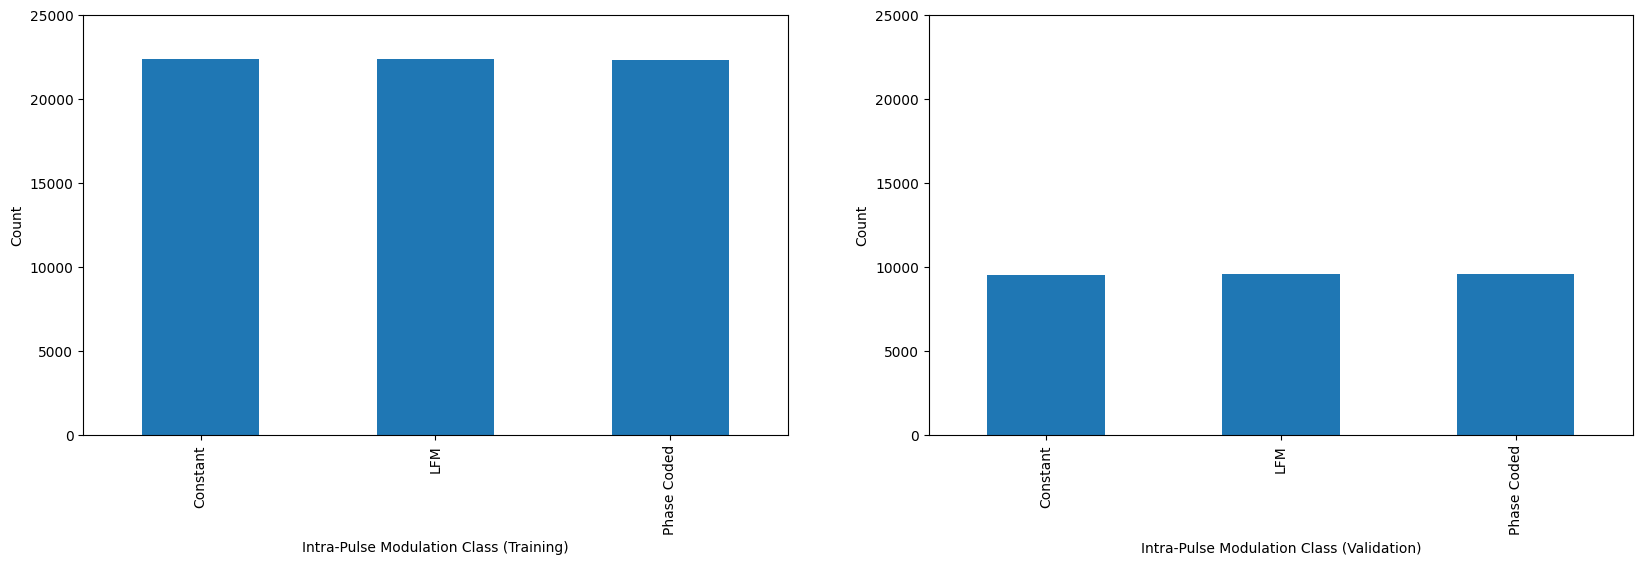

In [40]:
# Define bin edges
bins = [0, 1, 2, 3]  # Define edges for the bins
labels = ['Constant', 'LFM', 'Phase Coded']  # Optional labels for the bins

count_pm_mod_train['binned'] = pd.cut(y_train_class, bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
bin_counts_train = count_pm_mod_train['binned'].value_counts().sort_index()

# Print the counts for verification
print(bin_counts_train);

count_pm_mod_val['binned'] = pd.cut(y_val_class, bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
bin_counts_val = count_pm_mod_val['binned'].value_counts().sort_index()

# Print the counts for verification
print(bin_counts_val);

fig = plt.figure(figsize=[20, 12])
ax1 = fig.add_subplot(2, 2, 1)
bin_counts_train.plot(kind='bar')
plt.xlabel('Intra-Pulse Modulation Class (Training)')
plt.ylabel('Count')
plt.ylim([0, 25000])
ax2 = fig.add_subplot(2, 2, 2)
bin_counts_val.plot(kind='bar');
plt.xlabel('Intra-Pulse Modulation Class (Validation)')
plt.ylabel('Count')
plt.ylim([0, 25000])
plt.show()

pri_class
Constant     564
Jittered     545
Staggered    571
Name: count, dtype: int64
pri_class
Constant     236
Jittered     255
Staggered    229
Name: count, dtype: int64


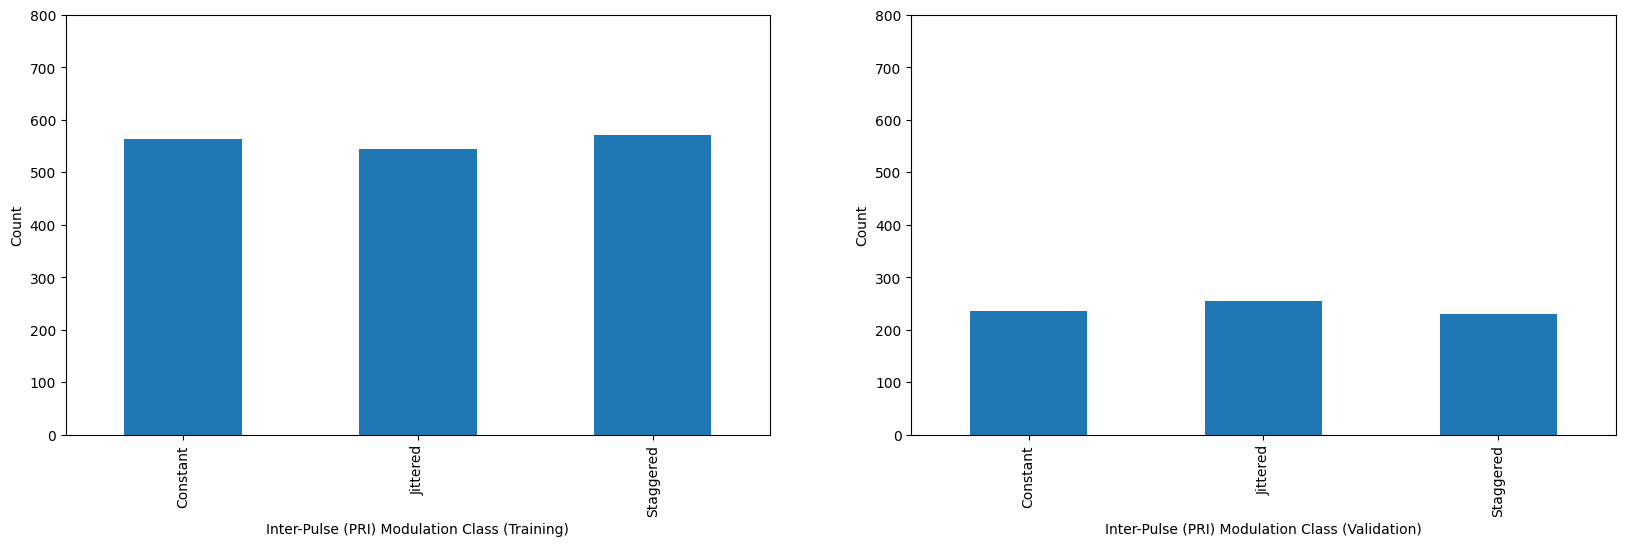

In [39]:
pri_count_train_labels = y_pri_train.copy();
pri_count_train_labels = pri_count_train_labels.squeeze()
pri_count_val_labels = y_pri_val.copy()
pri_count_val_labels = pri_count_val_labels.squeeze()

count_pri_mod_train = pri_count_train_labels.value_counts();
count_pri_mod_val = pri_count_val_labels.value_counts();

# Define bin edges
bins = [0, 1, 2, 3]  # Define edges for the bins
labels = ['Constant', 'Jittered', 'Staggered']  # Optional labels for the bins

count_pri_mod_train['binned'] = pd.cut(pri_count_train_labels, bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
bin_counts_train = count_pri_mod_train['binned'].value_counts().sort_index()

# Print the counts for verification
print(bin_counts_train);

count_pri_mod_val['binned'] = pd.cut(pri_count_val_labels, bins=bins, labels=labels, right=False)

# Count the number of entries in each bin
bin_counts_val = count_pri_mod_val['binned'].value_counts().sort_index()

# Print the counts for verification
print(bin_counts_val);

fig = plt.figure(figsize=[20, 12])
ax1 = fig.add_subplot(2, 2, 1)
bin_counts_train.plot(kind='bar')
plt.xlabel('Inter-Pulse (PRI) Modulation Class (Training)')
plt.ylabel('Count')
plt.ylim([0, 800])
ax2 = fig.add_subplot(2, 2, 2)
bin_counts_val.plot(kind='bar');
plt.xlabel('Inter-Pulse (PRI) Modulation Class (Validation)')
plt.ylabel('Count')
plt.ylim([0, 800])
plt.show()


# 3. Class Definition
Tokenizer, Position Embedding, MLP, Transformer Block

In [12]:
class PatchTokenizer(layers.Layer):
    # Initialise the layer.

    def __init__(
        self,
        patch_size,
        #kernel_size=3,
        #stride=1,
        #padding=1,
        #pooling_kernel_size=3,
        #pooling_stride=1,
        #num_conv_layers=1,
        # NOTE - tieing this to our projection_dim. Need to have the final output being the same as projection_dim
        #num_output_channels=[projection_dim // 2, 1], #1d output channel (LS edit)
        #positional_emb=positional_emb,
        projection_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim

        # Tokenizer
        self.conv1 = layers.Conv1D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid') # single convolutional layer. kernel size was patch_size
        self.flatten = layers.Reshape((-1, projection_dim))

        # Add CLS (Classification) Token
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, projection_dim),
            initializer = initializers.LecunNormal(), #was zeros
            trainable = True
            )

    def call(self, inputs):
        outputs = self.conv1(inputs) #extract patches
        outputs = self.flatten(outputs) #flatten patches into sequence
        cls_tokens = tf.broadcast_to(self.cls_token, [tf.shape(outputs)[0], 1, self.projection_dim])
        outputs = tf.concat([cls_tokens, outputs], axis=1)
        return outputs

class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        projection_dim,
        initializer=initializers.LecunNormal(), #was glorot_uniform
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.projection_dim = projection_dim
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        # feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="position_embeddings",
            shape=(self.sequence_length + 1, self.projection_dim), #+1 for CLS token
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        position_embeddings = tf.broadcast_to(self.position_embeddings, [batch_size, self.sequence_length + 1, self.projection_dim])
        return inputs + position_embeddings


# Create simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )

        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

# 4. Model Creation - Tokenizer + Transformer (AST)

**Per: https://keras.io/examples/vision/token_learner/**

In [13]:
positional_emb = True
batch_size = 64 # per reference
steps_per_epoch = X_train_std.shape[0] // batch_size
#steps_per_epoch = (X_train_std.shape[0] + batch_size - 1) // batch_size
num_epochs = 20

input_shape = (3000, 2) # X_train.shape

# Patch Dimensions
sequence_length = 3000                   # Sequence Length
patch_size = 100                         # 30 patches once flattened (was 64)
num_patches = (sequence_length // patch_size) ## number of patches, derived from the above two parameters
projection_dim = 1536                    #was 728

## tranformer parameters
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding (was 768)
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [512]             # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer


# define patch creation as a layer (note that this layer has no learned parameters).


def create_mtl_classifier(input_shape, patch_size):

    inputs = layers.Input(shape=input_shape, name='Raw IQ Data')

    ## CLS tokens concatenated to patch embedding per https://github.com/YuanGongND/ast/blob/master/src/models/ast_models.py#L165
    ## Entire embedding considered for classification

    # Create & Encode patches
    patches = PatchTokenizer(patch_size=patch_size, projection_dim=projection_dim)
    encoded_patches = patches(inputs) #tokenize data and create patches

    # Apply embedding
    position_embedding = PositionEmbedding(sequence_length=num_patches, projection_dim=projection_dim)
    encoded_patches = position_embedding(encoded_patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    embedding = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

#  # first classification branch - Number Pulses - regression
    class_1 = layers.Dense(32, activation='relu', kernel_initializer=initializers.LecunNormal())(embedding)
    class_1 = layers.Dropout(0.5)(class_1)
    class_1 = layers.Dense(1, name='1_num_pulses')(class_1)

#     # second classification branch - Pulse Width - regression
    class_2 = layers.Dense(32, activation='relu', kernel_initializer=initializers.LecunNormal())(embedding)
    class_2 = layers.Dropout(0.5)(class_2)
    class_2 = layers.Dense(1, name='2_pulse_width')(class_2)

#     # third classification problem - PRI - regression
    class_3 = layers.Dense(32, activation='relu', kernel_initializer=initializers.LecunNormal())(embedding)
    class_3 = layers.Dropout(0.5)(class_3)
    class_3 = layers.Dense(1, name='3_PRI')(class_3)

#     # # # # # fourth classification problem - Pulse Time Delay - regression
    class_4 = layers.Dense(32, activation='relu', kernel_initializer=initializers.LecunNormal())(embedding)
    class_4 = layers.Dropout(0.5)(class_4)
    class_4 = layers.Dense(1, name='4_pulse_time_delay')(class_4)

   # fifth classification problem - Pulse Modulation Class - classification
    class_5 = layers.Dense(32, activation='relu', kernel_initializer=initializers.LecunNormal())(embedding)
    class_5 = layers.Dropout(0.5)(class_5)
    class_5 = layers.Dense(3, activation='softmax', name='5_class')(class_5) #softmax for multi-class classification

    # Classify outputs.
    MTL = ([class_1, class_2, class_3, class_4, class_5])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=MTL) #class_5

    return model

mtl_classifier = create_mtl_classifier(input_shape, patch_size)


# Compile & Train

In [21]:
#mtl_classifier = create_mtl_classifier(input_shape, patch_size)
print(mtl_classifier.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Raw IQ Data (InputLayer)  │ (None, 3000, 2)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_tokenizer_3         │ (None, 31, 1536)       │        310,272 │ Raw IQ Data[0][0]      │
│ (PatchTokenizer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_1      │ (None, 31, 1536)       │         47,616 │ patch_tokenizer_3[0][… │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_3       │ (None, 31, 1536)       │     37,774,848 │ position_embedding_1[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_4       │ (None, 31, 1536)       │     37,774,848 │ transformer_block_3[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_5       │ (None, 31, 1536)       │     37,774,848 │ transformer_block_4[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 31, 1536)       │          3,072 │ transformer_block_5[0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 1536)           │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 1536)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 512)            │        786,944 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 512)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │         16,416 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │         16,416 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │         16,416 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 32)             │         16,416 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 32)             │         16,416 │ dropout_21[0][0]       │
├──────────────────────

 Total params: 114,554,759 (436.99 MB)

 Trainable params: 114,554,759 (436.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
#check all layers are trainable
for layer in mtl_classifier.layers:
  print(layer, layer.trainable)

<InputLayer name=Raw IQ Data, built=True> True
<PatchTokenizer name=patch_tokenizer_3, built=True> True
<PositionEmbedding name=position_embedding_1, built=True> True
<TransformerBlock name=transformer_block_3, built=True> True
<TransformerBlock name=transformer_block_4, built=True> True
<TransformerBlock name=transformer_block_5, built=True> True
<LayerNormalization name=layer_normalization_13, built=True> True
<GlobalAveragePooling1D name=global_average_pooling1d_1, built=True> True
<Dropout name=dropout_20, built=True> True
<Dense name=dense_13, built=True> True
<Dropout name=dropout_21, built=True> True
<Dense name=dense_14, built=True> True
<Dense name=dense_15, built=True> True
<Dense name=dense_16, built=True> True
<Dense name=dense_17, built=True> True
<Dense name=dense_18, built=True> True
<Dropout name=dropout_22, built=True> True
<Dropout name=dropout_23, built=True> True
<Dropout name=dropout_24, built=True> True
<Dropout name=dropout_25, built=True> True
<Dropout name=drop

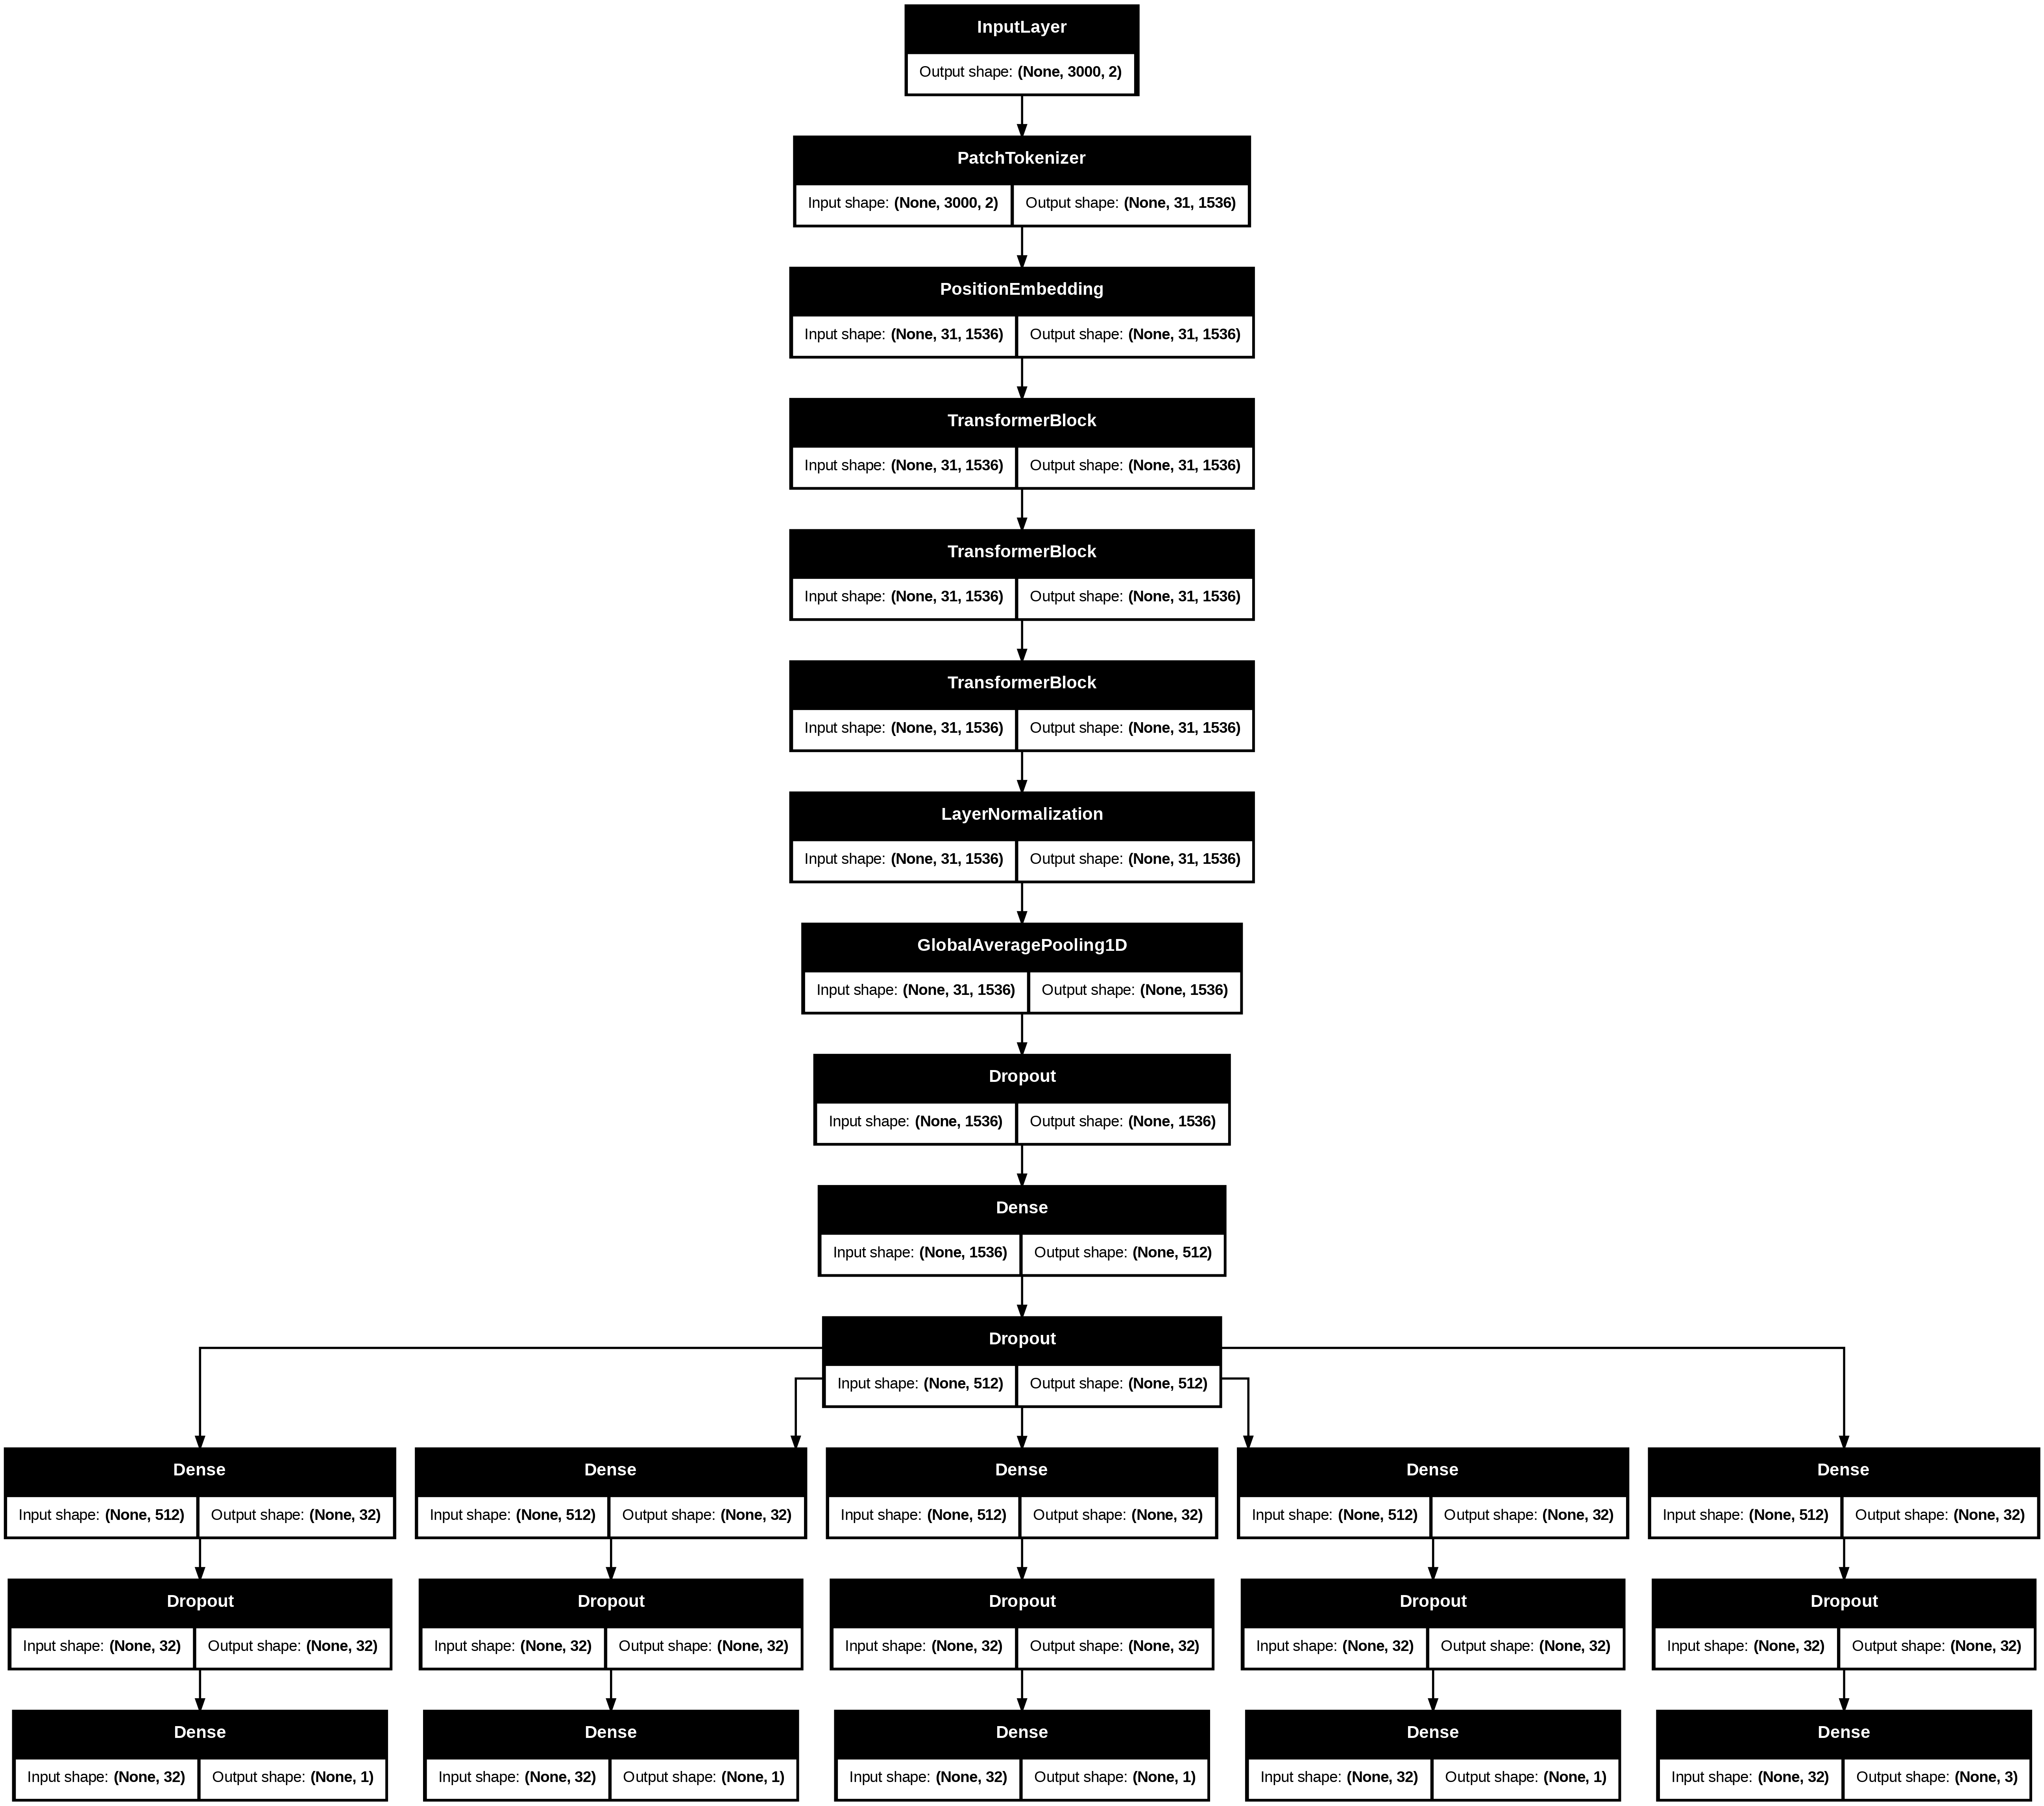

In [ ]:
plot_model(mtl_classifier, show_shapes=True) #to_file="drive/MyDrive/Colab Notebooks/ENN590/mtl_classifier_dataset2.png")

In [14]:
mtl_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #learning_rate=lr
                     loss={
                         '1_num_pulses': 'mean_absolute_error',
                         '2_pulse_width': 'mean_absolute_error',
                         '3_PRI': 'mean_absolute_error',
                         '4_pulse_time_delay': 'mean_absolute_error',
                         '5_class': keras.losses.CategoricalCrossentropy(from_logits=False)
                     },
                      metrics={
                         '1_num_pulses': ['mean_absolute_error'],
                         '2_pulse_width': ['mean_absolute_error'],
                         '3_PRI': ['mean_absolute_error'],
                         '4_pulse_time_delay': ['mean_absolute_error'],
                         '5_class': ['accuracy']
                      }
                       #jit_compile=False
                       )

## stop early callback set using test data
# stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# checkpoint saving to grab best model
# checkpoint_file = "model_checkpoint.keras"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_file,
#     # monitor="val_loss",
#     # mode='min',
#     save_best_only=True,
#     )

In [15]:
history = mtl_classifier.fit(X_train_std,
                            [y_train_np, y_train_pw, y_train_pri, y_train_td, labels_class_train], #
                            #steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            validation_data=(X_val_std, [y_val_np, y_val_pw, y_val_pri, y_val_td, labels_class_val]), #
                            # callbacks=[checkpoint_callback] #stop_early,
                            )

Epoch 1/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 542s 247ms/step - 1_num_pulses_mean_absolute_error: 0.3665 - 2_pulse_width_mean_absolute_error: 0.3644 - 3_PRI_mean_absolute_error: 0.3238 - 4_pulse_time_delay_mean_absolute_error: 0.3892 - 5_class_accuracy: 0.5928 - loss: 2.2539 - val_1_num_pulses_mean_absolute_error: 0.1614 - val_2_pulse_width_mean_absolute_error: 0.2360 - val_3_PRI_mean_absolute_error: 0.1537 - val_4_pulse_time_delay_mean_absolute_error: 0.1649 - val_5_class_accuracy: 0.9868 - val_loss: 0.8032
Epoch 2/20
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 520s 248ms/step - 1_num_pulses_mean_absolute_error: 0.1964 - 2_pulse_width_mean_absolute_error: 0.2702 - 3_PRI_mean_absolute_error: 0.2087 - 4_pulse_time_delay_mean_absolute_error: 0.2627 - 5_class_accuracy: 0.9670 - loss: 1.1100 - val_1_num_pulses_mean_absolute_error: 0.1529 - val_2_pulse_width_mean_absolute_error: 0.2052 - val_3_PRI_mean_absolute_error: 0.1344 - val_4_pulse_time_delay_mean_absolute_error: 0.1602 - val_5_class_accuracy: 0.9942

In [56]:
#mtl_classifier.save('drive/MyDrive/Data/mtl_classifier.keras')

In [ ]:
print("Shapes of input data:")
print("X_train:", X_train_std.shape)
print("X_val:", X_val_std.shape)

print("\nShapes of labels:")
print("labels_class_train:", labels_class_train.shape)
print("labels_class_val:", labels_class_val.shape)

Shapes of input data:
X_train: (67200, 3000, 2)
X_val: (14400, 3000, 2)

Shapes of labels:
labels_class_train: (67200, 3)
labels_class_val: (14400, 3)


In [ ]:
labels_class_train[0]

array([1., 0., 0., 0., 0.], dtype=float32)

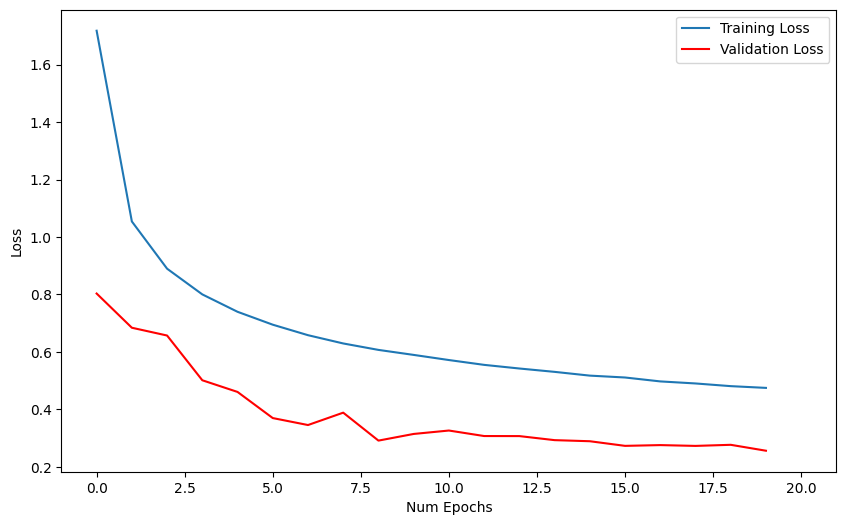

In [21]:
## Training & Validation Loss

plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.xlim([-1, 21])
plt.legend();

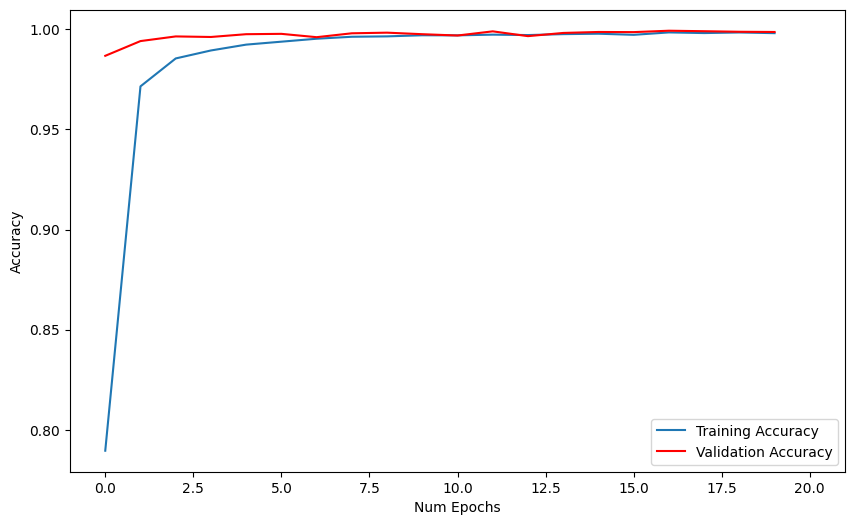

In [22]:
## Training & Validation Accuracy

plt.figure(figsize=[10, 6])
plt.plot(history.history['5_class_accuracy'], label="Training Accuracy")
plt.plot(history.history['val_5_class_accuracy'], label="Validation Accuracy", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.xlim([-1, 21])
plt.legend();

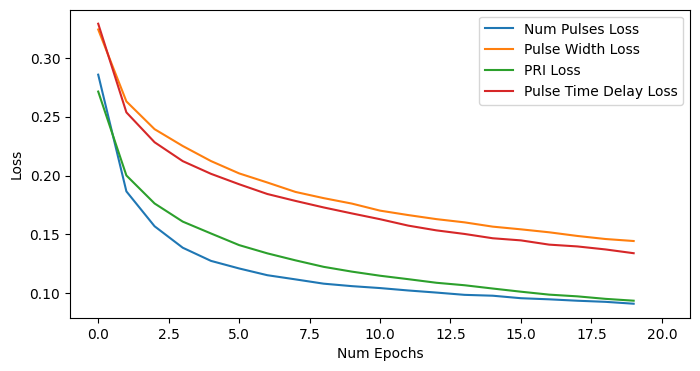

In [23]:
## Training Loss

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.xlim([-1, 21])
plt.legend();

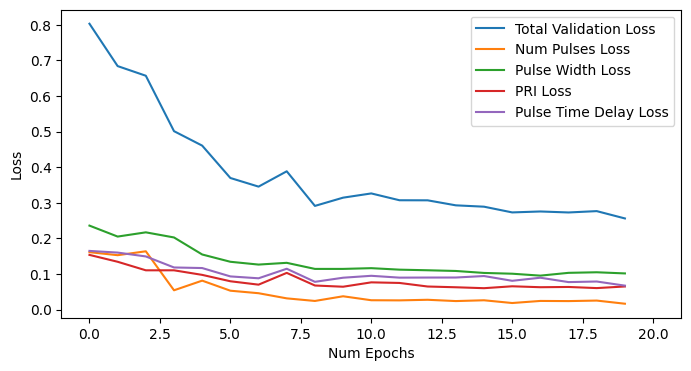

In [24]:
## Validation Loss with Total Loss

plt.figure(figsize=[8, 4])
plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.xlim([-1, 21])
plt.legend()

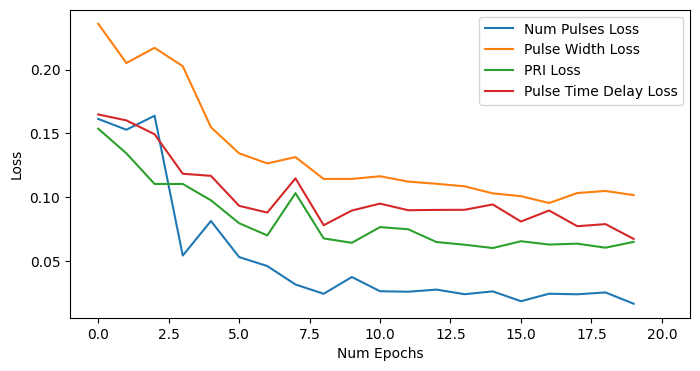

In [25]:
#Validation Loss Only

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.xlim([-1, 21])
plt.legend();

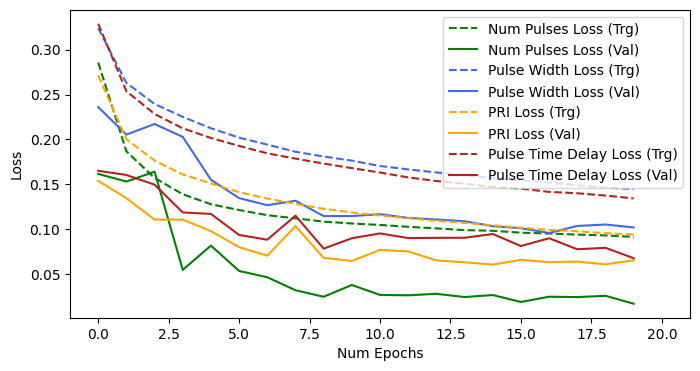

In [26]:
## Training & Validation Loss - Same curve

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['1_num_pulses_mean_absolute_error'], label="Num Pulses Loss (Trg)", linestyle="dashed", color="green")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss (Val)", color="green")
plt.plot(history.history['2_pulse_width_mean_absolute_error'], label="Pulse Width Loss (Trg)", linestyle="dashed", color="royalblue")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss (Val)", color="royalblue")
plt.plot(history.history['3_PRI_mean_absolute_error'], label="PRI Loss (Trg)",  linestyle="dashed", color="orange")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss (Val)", color="orange")
plt.plot(history.history['4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss (Trg)",  linestyle="dashed", color="firebrick")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss (Val)", color="firebrick")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.xlim([-1, 21])
plt.legend();

#PRI Classification

In [27]:
print(data_pri.shape)
print(labels_pri.shape)

data_pri = data_pri.reshape((2400, 40, 1))  # Reshape to (num_samples, sequence_length, num_features)
labels_pri = labels_pri.reshape((2400,))  # Reshape to match the number of samples

print(data_pri.shape)
print(labels_pri.shape)

(40, 2400)
(2400, 1)
(2400, 40, 1)
(2400,)


In [28]:
column_names = ['pri_class']
labels_pri = pd.DataFrame(labels_pri, columns=column_names)
print(labels_pri)

# pri class
labels_pri['pri_class'] = labels_pri['pri_class'] - 1 # reposition to start at index 0

      pri_class
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
...         ...
2395        3.0
2396        3.0
2397        3.0
2398        3.0
2399        3.0

[2400 rows x 1 columns]


In [29]:
# 70 - 15 - 15 Train/Val/Test split per Reference

X_pri_train, X_pri_val, y_pri_train, y_pri_val = train_test_split(data_pri,labels_pri,
                                   random_state=16,
                                   test_size=0.30,
                                   shuffle=True)

#X_pri_val_test_split y_pri_val_test_split

In [34]:
print(y_pri_train)

      pri_class
871         1.0
1751        2.0
250         0.0
120         0.0
917         1.0
...         ...
452         0.0
635         0.0
1345        1.0
581         0.0
2169        2.0

[1680 rows x 1 columns]


In [ ]:
# standardize against training population mean & variance

train_pri_mean = X_pri_train.mean()
train_pri_sigma = X_pri_train.std()

X_pri_train_std = (X_pri_train - train_pri_mean)/(train_pri_sigma)
X_pri_val_std = (X_pri_val - train_pri_mean)/(train_pri_sigma)

#X_pri_val_test_std = (X_pri_val_test_split - train_pri_mean)/(train_pri_sigma)

# print(train_mean)

In [ ]:
# create val/test split

# X_pri_val, X_pri_test, y_pri_val, y_pri_test = train_test_split(X_pri_val_test_std,y_pri_val_test_split,
#                                    random_state=32,
#                                    test_size=0.50,
#                                    shuffle=True)

In [ ]:
print("Train Split Size:", X_pri_train_std.shape)
print("Validation Split Size:", X_pri_val.shape)
#print("Test Split Size:", X_pri_test.shape)

Train Split Size: (1680, 40, 1)
Validation Split Size: (720, 40, 1)


In [36]:
## Train Split
labels_pri_train = to_categorical(y_pri_train, num_classes=3)

## Validation Split
labels_pri_val = to_categorical(y_pri_val, num_classes=3)

## Test Split
#labels_pri_test = to_categorical(y_pri_test, num_classes=3)

In [ ]:
input_shape = (40,1) # X_train.shape

positional_emb = True
batch_size =  32
lr = 0.0002
steps_per_epoch = X_pri_train_std.shape[0] // batch_size
num_epochs = 100

# Patch Dimensions
sequence_length = 40                    # Sequence Length
patch_size = 8                          # patch size, how big is each "element" in our sequence? This should be a factor of the image size
num_patches = (sequence_length // patch_size) ## number of patches, derived from the above two parameters
projection_dim = 16

## tranformer parameters
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding (was 768)
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [16]                   # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer

def create_pri_classifier(input_shape, patch_size):

    inputs = layers.Input(shape=input_shape, name='PRI Modulation Sequence')

    # Create & Encode patches
    patches = PatchTokenizer(patch_size=patch_size, projection_dim=projection_dim)
    encoded_patches = patches(inputs) #tokenize data and create patches

    # Apply embedding
    position_embedding = PositionEmbedding(sequence_length=num_patches, projection_dim=projection_dim)
    encoded_patches = position_embedding(encoded_patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    embedding = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # first classification - PRI Modulation Class - classification
    # pri_mod_class = layers.Dense(64, activation='relu')(embedding)
    # pri_mod_class = layers.Dropout(0.5)(pri_mod_class)
    pri_mod_class = layers.Dense(32, activation='relu')(embedding)
    pri_mod_class = layers.Dropout(0.5)(pri_mod_class)
    pri_mod_class = layers.Dense(16, activation='relu')(pri_mod_class)
    pri_mod_class = layers.Dense(3, activation='softmax', name='1_pri_mod_class')(pri_mod_class)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=pri_mod_class)

    return model

pri_mod_classifier = create_pri_classifier(input_shape, patch_size)

In [ ]:
pri_mod_classifier.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ PRI Modulation Sequence (InputLayer) │ (None, 40, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_tokenizer (PatchTokenizer)     │ (None, 6, 16)               │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ position_embedding                   │ (None, 6, 16)               │              96 │
│ (PositionEmbedding)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 6, 16)               │           4,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 6, 16)               │           4,368 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ (None, 6, 16)               │           4,368 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_6                │ (None, 6, 16)               │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1_pri_mod_class (Dense)              │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,787 (57.76 KB)

 Trainable params: 14,787 (57.76 KB)

 Non-trainable params: 0 (0.00 B)

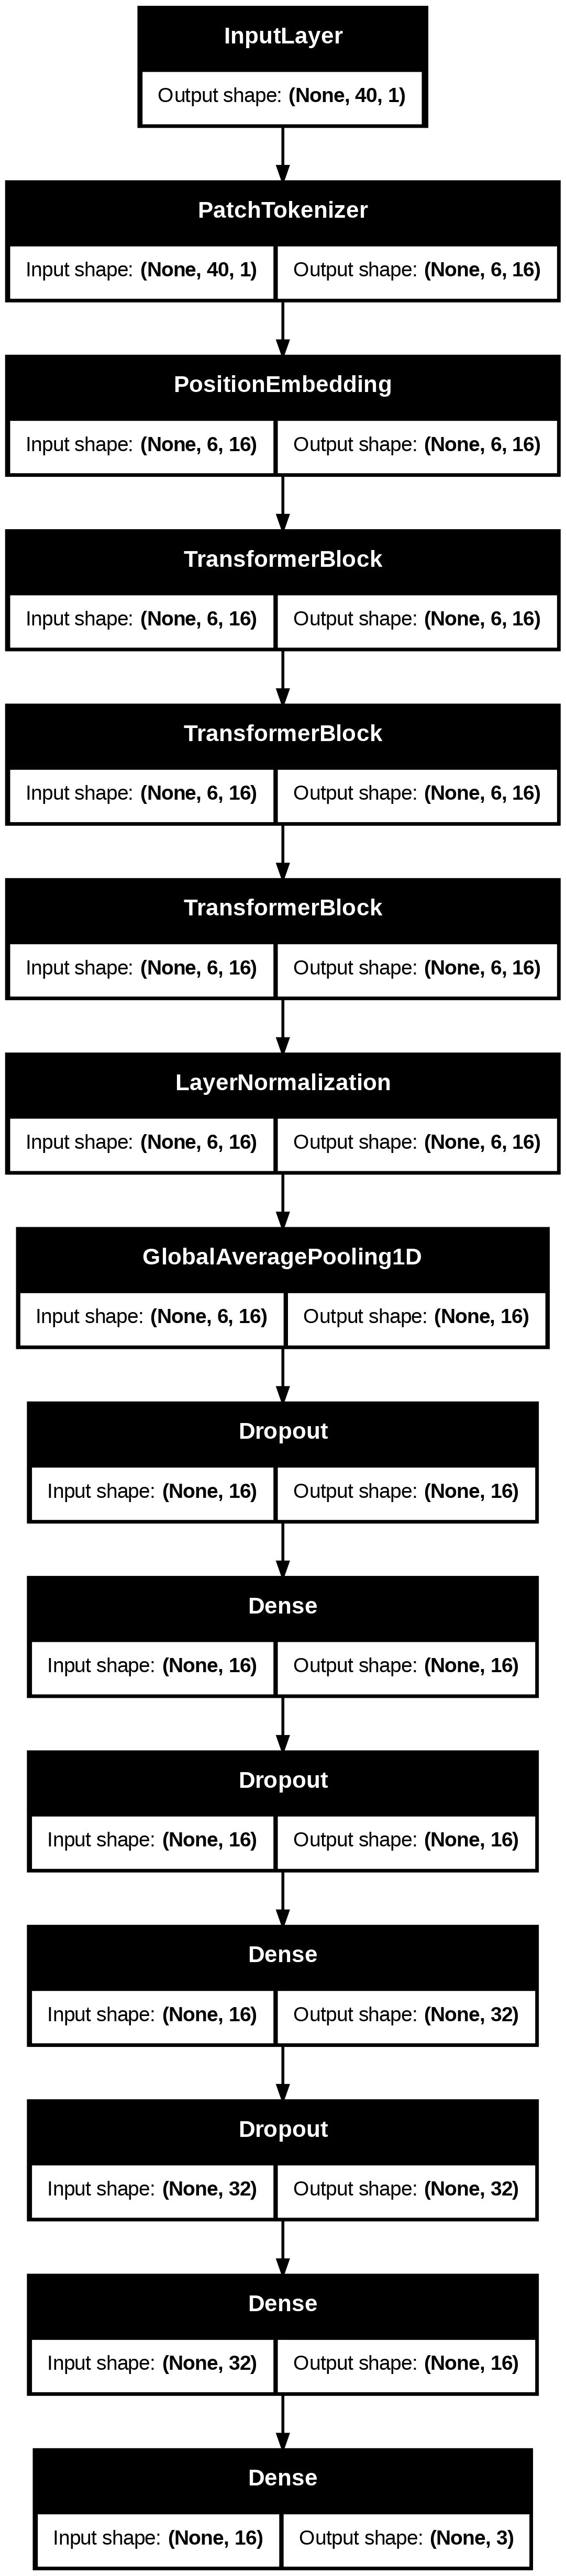

In [ ]:
plot_model(pri_mod_classifier, show_shapes=True)

In [ ]:
pri_mod_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss={
                         '1_pri_mod_class': keras.losses.CategoricalCrossentropy(from_logits=False)
                     },
                      metrics={
                         '1_pri_mod_class': ['accuracy']
                      }
                       )

In [ ]:
history = pri_mod_classifier.fit(X_pri_train_std,
                            labels_pri_train,
                            #steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            validation_data=(X_pri_val_std, labels_pri_val),
                            #callbacks=stop_early
                            )

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.3525 - loss: 1.1887 - val_accuracy: 0.3639 - val_loss: 1.0785
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3433 - loss: 1.1503 - val_accuracy: 0.3611 - val_loss: 1.0820
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3499 - loss: 1.1225 - val_accuracy: 0.4236 - val_loss: 1.0867
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3370 - loss: 1.1245 - val_accuracy: 0.5139 - val_loss: 1.0884
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3854 - loss: 1.0929 - val_accuracy: 0.4819 - val_loss: 1.0889
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3816 - loss: 1.0982 - val_accuracy: 0.5653 - val_loss: 1.0764
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4066 - loss: 1.0988 - val_accuracy: 0.5875 - val_loss: 1.0640
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4075 - loss: 1.0870 - val_accuracy: 0.5903 

# PRI Modulation Analysis

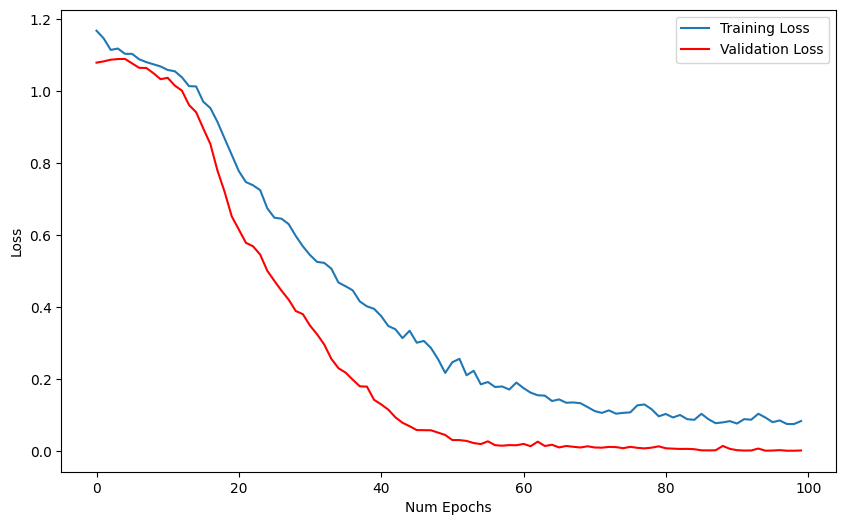

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend();

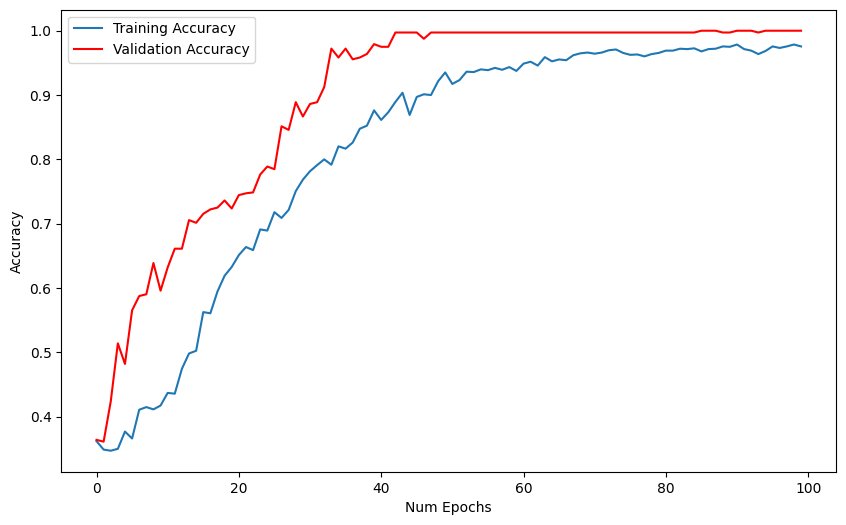

In [ ]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.legend();

# Figures for AST [Archive]

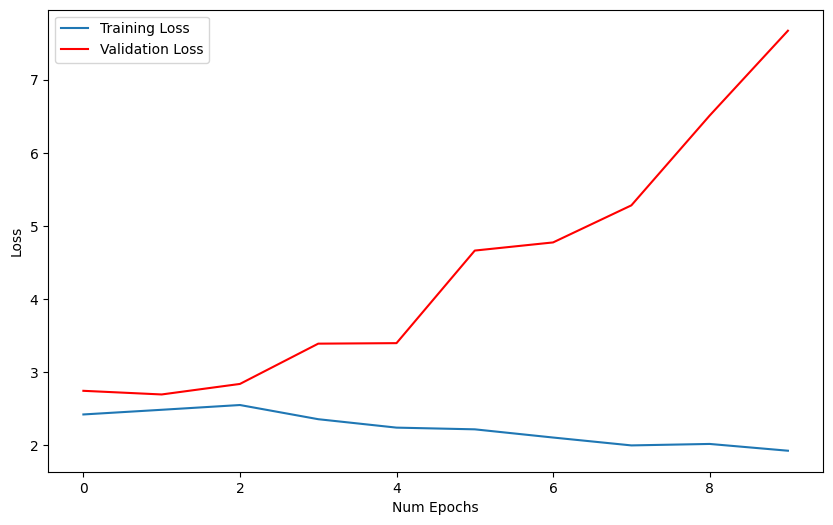

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

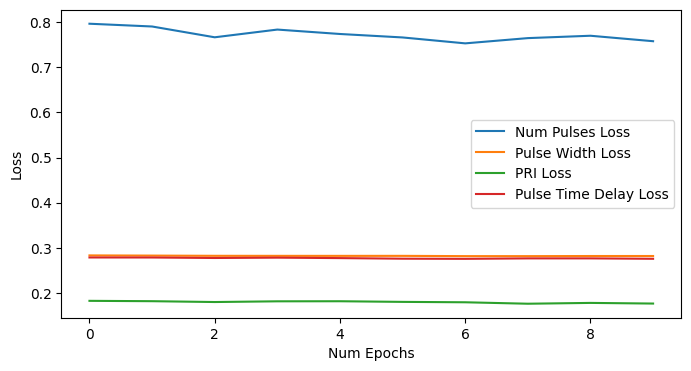

In [ ]:
plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

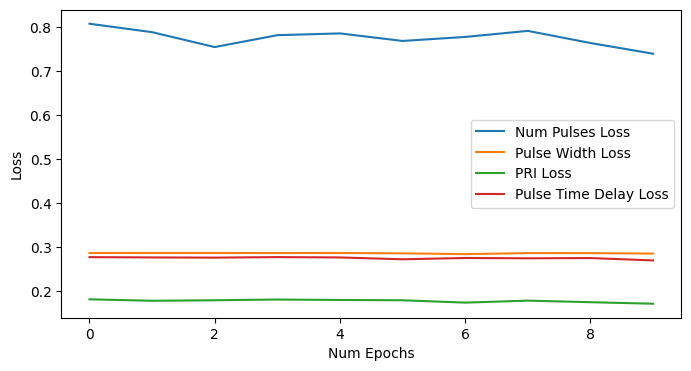

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

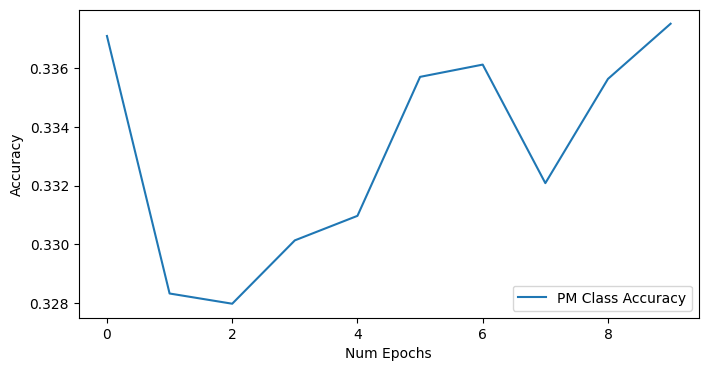

In [ ]:
plt.figure(figsize=[8, 4])
plt.plot(history.history['val_5_class_accuracy'], label="PM Class Accuracy")
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Transformer Only [Archive]

In [ ]:

batch_size = 64 # per reference
lr = 0.0005 # per reference
steps_per_epoch = X_train_std.shape[0] // batch_size
num_epochs = 10

input_shape = (3000, 2) # X_train.shape

# Patch Dimensions
sequence_length = 3000                   # Sequence Length
#patch_size = 60                         # patch size, how big is each "element" in our sequence? This should be a factor of the image size
                                        # 8 patches per reference once flattened
#num_patches = (sequence_length // patch_size) ## number of patches, derived from the above two parameters
projection_dim = 768

## tranformer parameters
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding (was 768)
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [512]             # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer


# Create simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )

        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

def create_mtl_classifier(input_shape, patch_size):

    inputs = layers.Input(shape=input_shape, name='Raw IQ Data')

    # Project the input to the desired projection dimension
    x = layers.Dense(projection_dim, activation='relu')(inputs)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(x)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(x)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    embedding = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

#  # first classification branch - Number Pulses - regression
#     # class_1 = layers.Conv1D(64, 3, activation=None, padding='same')(embedding)
#     # class_1 = layers.BatchNormalization(axis=1)(class_1)
#     # class_1 = layers.Activation('relu')(class_1)
#     # class_1 = layers.Dropout(0.25)(class_1)
    class_1 = layers.Dense(32, activation='relu')(embedding)
    class_1 = layers.Dropout(0.5)(class_1)
    class_1 = layers.Dense(1, name='1_num_pulses')(class_1)

#     # second classification branch - Pulse Width - regression
#     # class_2 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_2 = layers.BatchNormalization(axis=1)(class_2)
#     # class_2 = layers.Activation('relu')(class_2)
#     # class_2 = layers.Dropout(0.25)(class_2)
    class_2 = layers.Dense(32, activation='relu')(embedding)
    class_2 = layers.Dropout(0.5)(class_2)
    class_2 = layers.Dense(1, name='2_pulse_width')(class_2)

#     # third classification problem - PRI - regression
#     # class_3 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_3 = layers.BatchNormalization(axis=1)(class_3)
#     # class_3 = layers.Activation('relu')(class_3)
#     # class_3 = layers.Dropout(0.25)(class_3)
    class_3 = layers.Dense(32, activation='relu')(embedding)
    class_3 = layers.Dropout(0.5)(class_3)
    class_3 = layers.Dense(1, name='3_PRI')(class_3)

#     # # # # # fourth classification problem - Pulse Time Delay - regression
#     # class_4 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_4 = layers.BatchNormalization(axis=1)(class_4)
#     # class_4 = layers.Activation('relu')(class_4)
#     # class_4 = layers.Dropout(0.25)(class_4)
    class_4 = layers.Dense(32, activation='relu')(embedding)
    class_4 = layers.Dropout(0.5)(class_4)
    class_4 = layers.Dense(1, name='4_pulse_time_delay')(class_4)

   # fifth classification problem - Pulse Modulation Class - classification
    # class_5 = layers.BatchNormalization(axis=1)(class_5)
    # class_5 = layers.Activation('relu')(class_5)
    # class_5 = layers.Dropout(0.25)(class_5)
    class_5 = layers.Dense(32, activation='relu')(embedding)
    class_5 = layers.Dropout(0.5)(class_5)
    class_5 = layers.Dense(5, activation='softmax', name='5_class')(class_5) #sigmoid instead of softmax?

    # Classify outputs.
    MTL = ([class_1, class_2, class_3, class_4, class_5])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=MTL)

    return model

mtl_classifier = create_mtl_classifier(input_shape, patch_size)


# AST + More Attention [Archive]

In [ ]:
positional_emb = True
batch_size = 64
#lr = 0.00001 # per reference
steps_per_epoch = X_train_std.shape[0] // batch_size
#steps_per_epoch = (X_train_std.shape[0] + batch_size - 1) // batch_size
num_epochs = 20

input_shape = (3000, 2) # X_train.shape

# Patch Dimensions
sequence_length = 3000                   # Sequence Length
patch_size = 60                         # patch size, how big is each "element" in our sequence? This should be a factor of the image size
num_patches = (sequence_length // patch_size) ## number of patches, derived from the above two parameters
projection_dim = 768

## tranformer parameters
num_heads = 4                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding (was 768)
transformer_layers = 4                  # number of transformer layres
mlp_head_units = [512]                  # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer

# define patch creation as a layer (note that this layer has no learned parameters).

class PatchTokenizer(layers.Layer):
    # Initialise the layer.

    def __init__(
        self,
        patch_size,
        projection_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim

        # Tokenizer
        self.conv1 = layers.Conv1D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid') # single convolutional layer. kernel size was patch_size
        self.flatten = layers.Reshape((-1, projection_dim))

        # Add CLS (Classification) Token
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, projection_dim),
            initializer = "zeros",
            trainable = True
            )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        outputs = self.conv1(inputs) #extract patches
        #print(f'Output shape after Conv1D: {outputs.shape}')  # Debug print
        outputs = self.flatten(outputs) #flatten patches into sequence
        #print(f'Output shape after Reshape: {outputs.shape}')  # Debug print
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.projection_dim])
        outputs = tf.concat([cls_tokens, outputs], axis=1)
        return outputs

class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, projection_dim, initializer="glorot_uniform", **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.projection_dim = projection_dim
        self.initializer = initializers.get(initializer)

    def build(self, input_shape):
        self.position_embeddings = self.add_weight(
            name="position_embeddings",
            shape=(self.sequence_length + 1, self.projection_dim),
            initializer=self.initializer,
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        position_embeddings = tf.broadcast_to(self.position_embeddings, [batch_size, self.sequence_length + 1, self.projection_dim])
        return inputs + position_embeddings

# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )

        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

# Create MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_mtl_classifier(input_shape, patch_size):

    inputs = layers.Input(shape=input_shape, name='Raw IQ Data')

    ## Entire embedding considered for classification

    # Create & Encode patches
    patches = PatchTokenizer(patch_size=patch_size, projection_dim=projection_dim)
    encoded_patches = patches(inputs) #tokenize data and create patches
    #print(f'Output shape after PatchTokenizer: {encoded_patches.shape}')  # Debug print

    # Apply embedding
    position_embedding = PositionEmbedding(sequence_length=num_patches, projection_dim=projection_dim)
    encoded_patches = position_embedding(encoded_patches)
    #print(f'Output shape after PositionEmbedding: {encoded_patches.shape}')  # Debug print

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)
        #print(f'Output shape after TransformerBlock: {encoded_patches.shape}')  # Debug print

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    embedding = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

#  # first classification branch - Number Pulses - regression
#     # class_1 = layers.Conv1D(64, 3, activation=None, padding='same')(embedding)
#     # class_1 = layers.BatchNormalization(axis=1)(class_1)
#     # class_1 = layers.Activation('relu')(class_1)
#     # class_1 = layers.Dropout(0.25)(class_1)
    class_1 = layers.Dense(32, activation='relu')(embedding)
    class_1 = layers.Dropout(0.5)(class_1)
    class_1 = layers.Dense(1, name='1_num_pulses')(class_1)

#     # second classification branch - Pulse Width - regression
#     # class_2 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_2 = layers.BatchNormalization(axis=1)(class_2)
#     # class_2 = layers.Activation('relu')(class_2)
#     # class_2 = layers.Dropout(0.25)(class_2)
    class_2 = layers.Dense(32, activation='relu')(embedding)
    class_2 = layers.Dropout(0.5)(class_2)
    class_2 = layers.Dense(1, name='2_pulse_width')(class_2)

#     # third classification problem - PRI - regression
#     # class_3 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_3 = layers.BatchNormalization(axis=1)(class_3)
#     # class_3 = layers.Activation('relu')(class_3)
#     # class_3 = layers.Dropout(0.25)(class_3)
    class_3 = layers.Dense(32, activation='relu')(embedding)
    class_3 = layers.Dropout(0.5)(class_3)
    class_3 = layers.Dense(1, name='3_PRI')(class_3)

#     # # # # # fourth classification problem - Pulse Time Delay - regression
#     # class_4 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_4 = layers.BatchNormalization(axis=1)(class_4)
#     # class_4 = layers.Activation('relu')(class_4)
#     # class_4 = layers.Dropout(0.25)(class_4)
    class_4 = layers.Dense(32, activation='relu')(embedding)
    class_4 = layers.Dropout(0.5)(class_4)
    class_4 = layers.Dense(1, name='4_pulse_time_delay')(class_4)

   # fifth classification problem - Pulse Modulation Class - classification
    # class_5 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
    # class_5 = layers.BatchNormalization(axis=1)(class_5)
    # class_5 = layers.Activation('relu')(class_5)
    #class_5 = layers.Dropout(0.25)(class_5)
    class_5 = layers.Dense(64, activation='relu')(embedding)
    class_5 = layers.Dropout(0.5)(class_5)
    class_5 = layers.Dense(32, activation='relu')(class_5)
    class_5 = layers.Dropout(0.5)(class_5)
    class_5 = layers.Dense(3, activation='softmax', name='5_class')(class_5) #sigmoid instead of softmax?

    # Classify outputs.
    MTL = ([class_1, class_2, class_3, class_4, class_5])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=MTL)

    return model

mtl_classifier = create_mtl_classifier(input_shape, patch_size)


In [ ]:
#mtl_classifier = create_mtl_classifier(input_shape, patch_size)
print(mtl_classifier.summary())

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Raw IQ Data (InputLayer)  │ (None, 3000, 2)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_tokenizer_7         │ (None, 51, 768)        │         93,696 │ Raw IQ Data[0][0]      │
│ (PatchTokenizer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_7      │ (None, 51, 768)        │         39,168 │ patch_tokenizer_7[0][… │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_20      │ (None, 51, 768)        │     11,811,840 │ position_embedding_7[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_21      │ (None, 51, 768)        │     11,811,840 │ transformer_block_20[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_22      │ (None, 51, 768)        │     11,811,840 │ transformer_block_21[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_23      │ (None, 51, 768)        │     11,811,840 │ transformer_block_22[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_53    │ (None, 51, 768)        │          1,536 │ transformer_block_23[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ layer_normalization_5… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_102 (Dropout)     │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_74 (Dense)          │ (None, 512)            │        393,728 │ dropout_102[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_103 (Dropout)     │ (None, 512)            │              0 │ dense_74[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_79 (Dense)          │ (None, 64)             │         32,832 │ dropout_103[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_108 (Dropout)     │ (None, 64)             │              0 │ dense_79[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_75 (Dense)          │ (None, 32)             │         16,416 │ dropout_103[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_76 (Dense)     

 Total params: 47,876,295 (182.63 MB)

 Trainable params: 47,876,295 (182.63 MB)

 Non-trainable params: 0 (0.00 B)

None


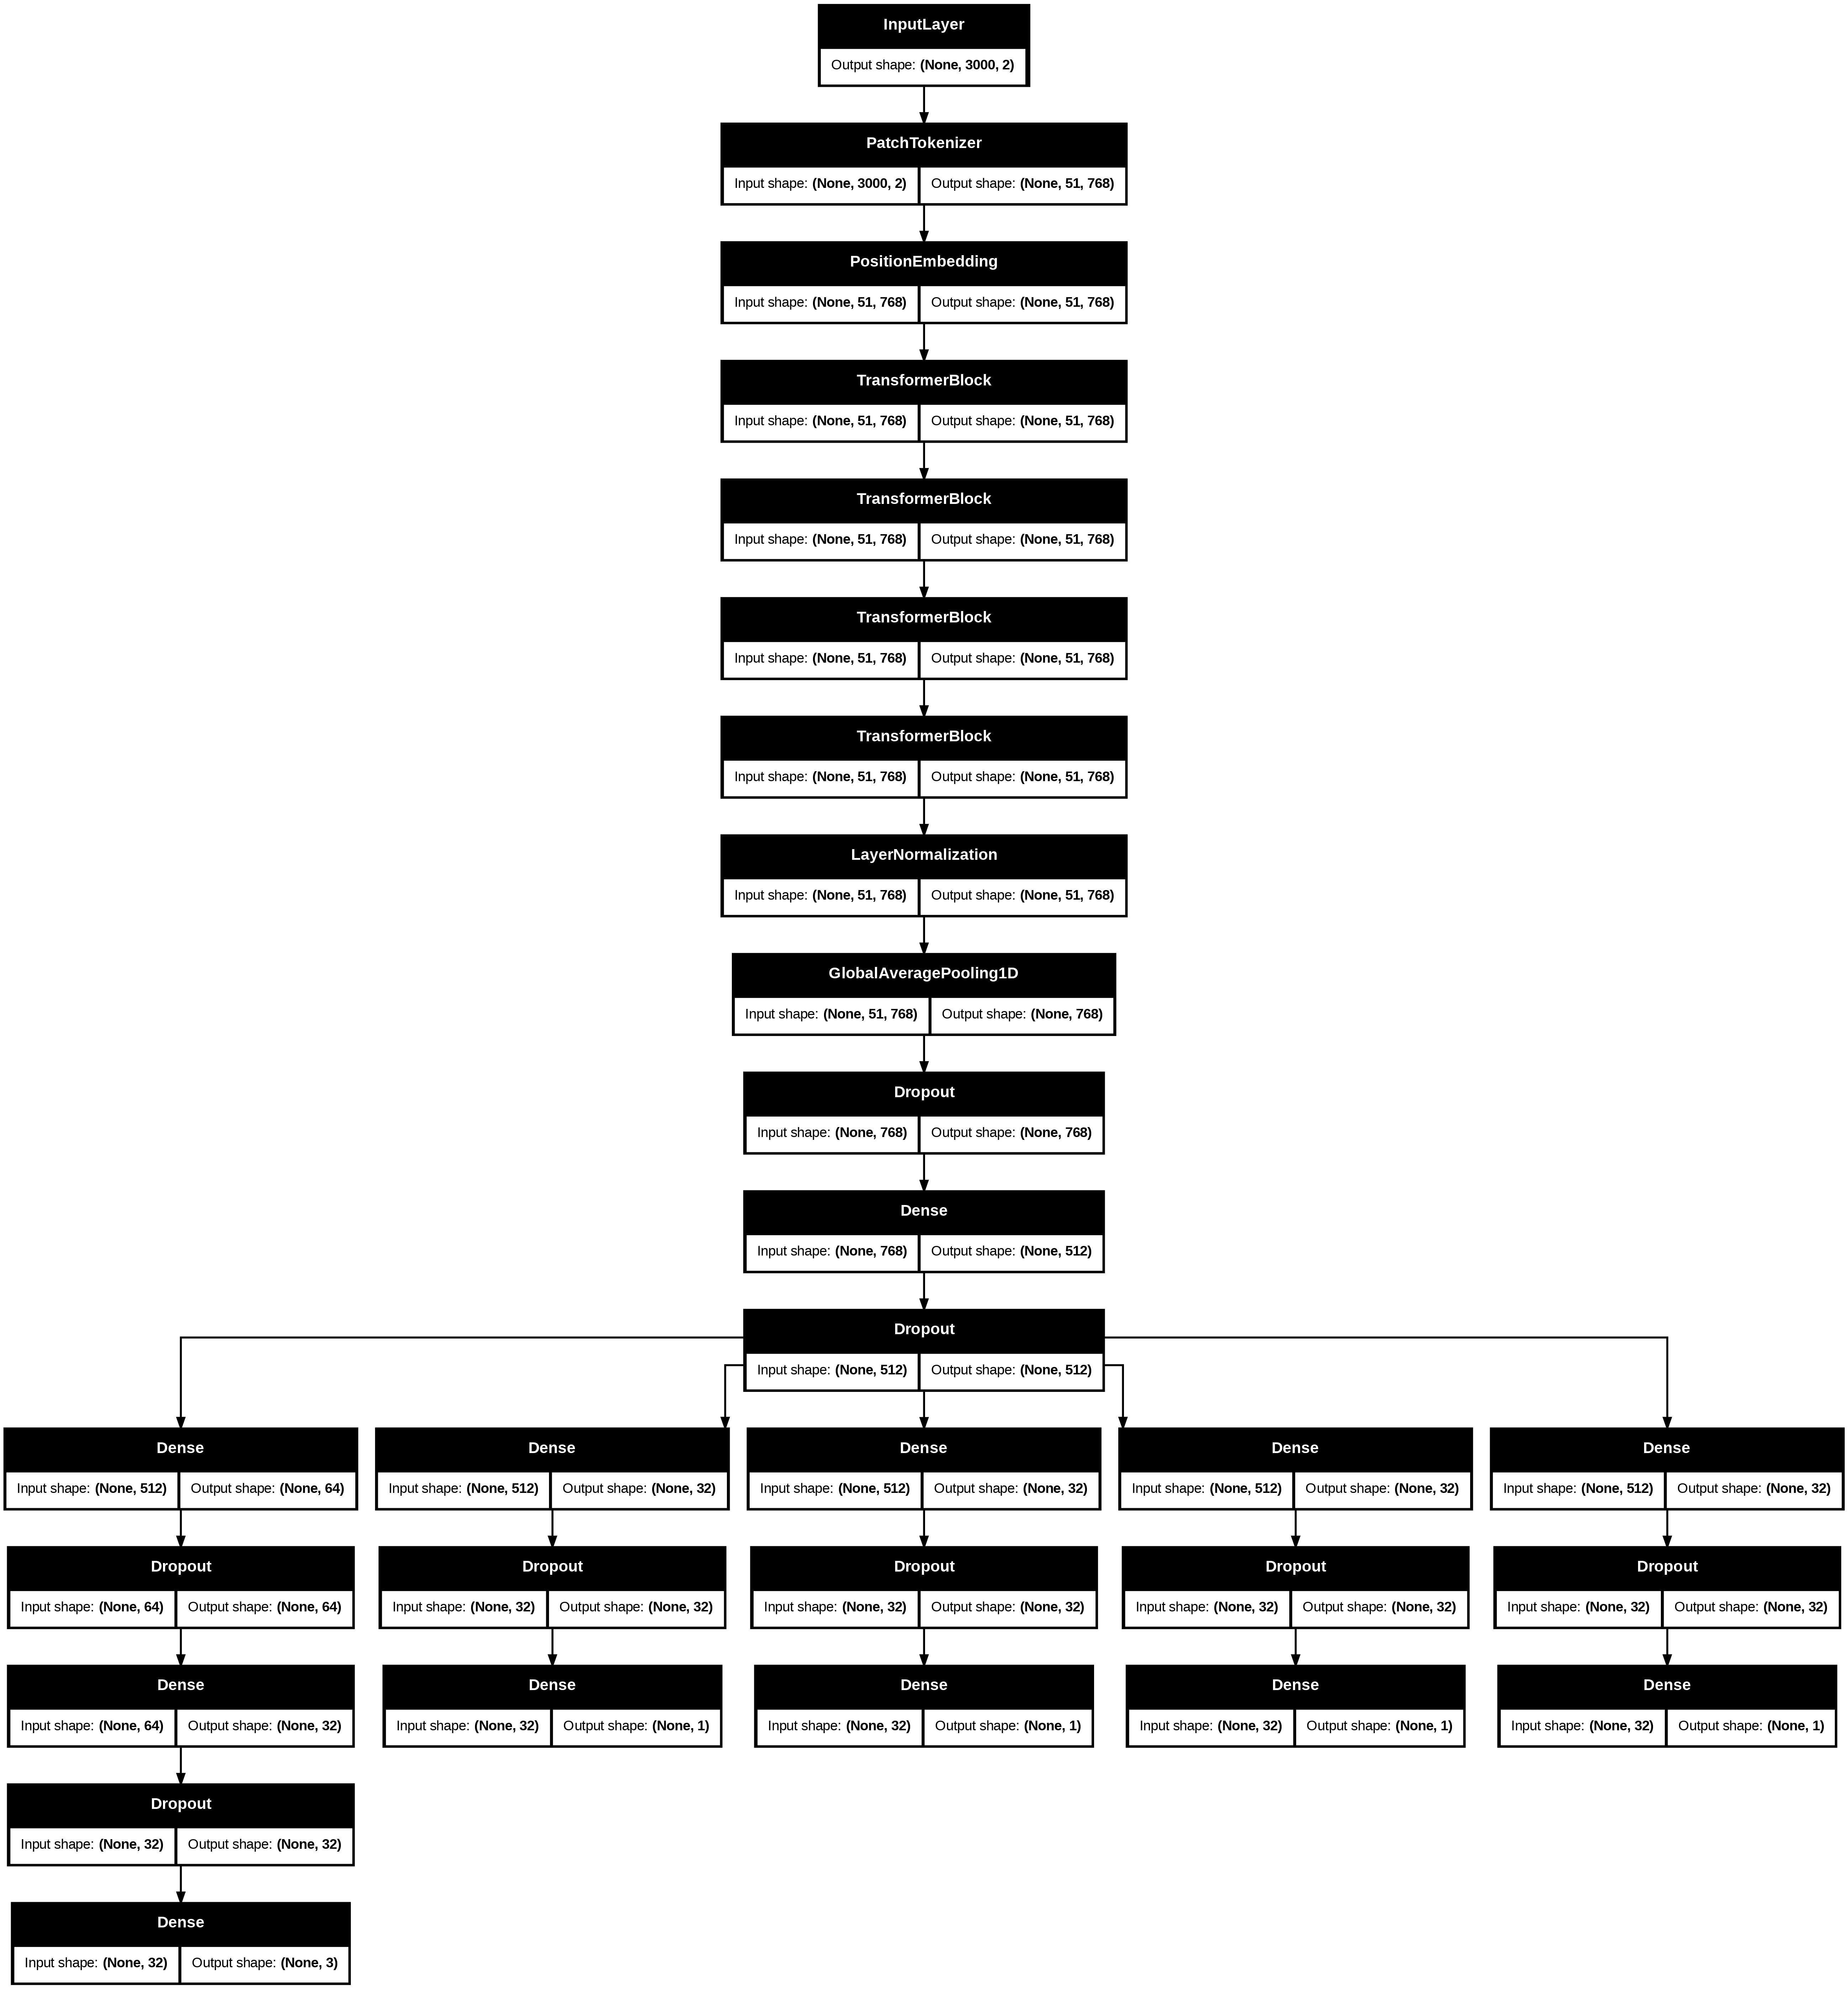

In [ ]:
plot_model(mtl_classifier, show_shapes=True) #to_file="drive/MyDrive/Colab Notebooks/ENN590/mtl_classifier_dataset2.png")

In [ ]:
mtl_classifier.compile(optimizer=tf.keras.optimizers.Adam(), #learning_rate=lr
                     loss={
                         '1_num_pulses': 'mean_absolute_error',
                         '2_pulse_width': 'mean_absolute_error',
                         '3_PRI': 'mean_absolute_error',
                         '4_pulse_time_delay': 'mean_absolute_error',
                         '5_class': keras.losses.CategoricalCrossentropy(from_logits=False)
                     },
                      metrics={
                         '1_num_pulses': ['mean_absolute_error'],
                         '2_pulse_width': ['mean_absolute_error'],
                         '3_PRI': ['mean_absolute_error'],
                         '4_pulse_time_delay': ['mean_absolute_error'],
                         '5_class': ['accuracy']
                      }
                       #jit_compile=False
                       )

## stop early callback set using test data
# stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# checkpoint saving to grab best model
# checkpoint_file = "model_checkpoint.keras"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_file,
#     # monitor="val_loss",
#     # mode='min',
#     save_best_only=True,
#     )

In [ ]:
history = mtl_classifier.fit(X_train_std,
                            [y_train_np, y_train_pw, y_train_pri, y_train_td, labels_class_train],
                            #steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            validation_data=(X_val, [y_val_np, y_val_pw, y_val_pri, y_val_td, labels_class_val]),
                            # callbacks=[checkpoint_callback] #stop_early,
                            )

Epoch 1/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 239s 103ms/step - 1_num_pulses_mean_absolute_error: 0.7992 - 2_pulse_width_mean_absolute_error: 0.2835 - 3_PRI_mean_absolute_error: 0.1814 - 4_pulse_time_delay_mean_absolute_error: 0.2789 - 5_class_accuracy: 0.6536 - loss: 2.2190 - val_1_num_pulses_mean_absolute_error: 0.8068 - val_2_pulse_width_mean_absolute_error: 0.2866 - val_3_PRI_mean_absolute_error: 0.1815 - val_4_pulse_time_delay_mean_absolute_error: 0.2773 - val_5_class_accuracy: 0.3371 - val_loss: 2.7457
Epoch 2/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 215s 102ms/step - 1_num_pulses_mean_absolute_error: 0.7943 - 2_pulse_width_mean_absolute_error: 0.2827 - 3_PRI_mean_absolute_error: 0.1824 - 4_pulse_time_delay_mean_absolute_error: 0.2785 - 5_class_accuracy: 0.5226 - loss: 2.4394 - val_1_num_pulses_mean_absolute_error: 0.7877 - val_2_pulse_width_mean_absolute_error: 0.2867 - val_3_PRI_mean_absolute_error: 0.1782 - val_4_pulse_time_delay_mean_absolute_error: 0.2766 - val_5_class_accuracy: 0.3283

In [ ]:
print("Shapes of input data:")
print("X_train:", X_train_std.shape)
print("X_val:", X_val.shape)

print("\nShapes of labels:")
print("labels_class_train:", labels_class_train.shape)
print("labels_class_val:", labels_class_val.shape)

Shapes of input data:
X_train: (67200, 3000, 2)
X_val: (14400, 3000, 2)

Shapes of labels:
labels_class_train: (67200, 3)
labels_class_val: (14400, 3)


In [ ]:
labels_class_train[0]

array([1., 0., 0., 0., 0.], dtype=float32)

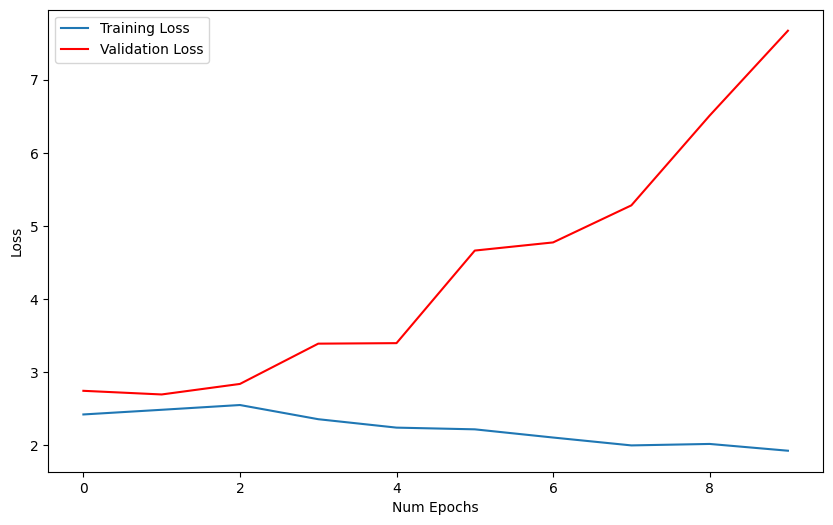

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", color='r')
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

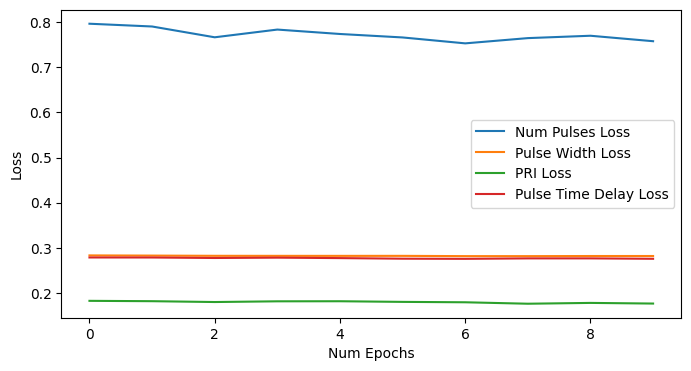

In [ ]:
plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

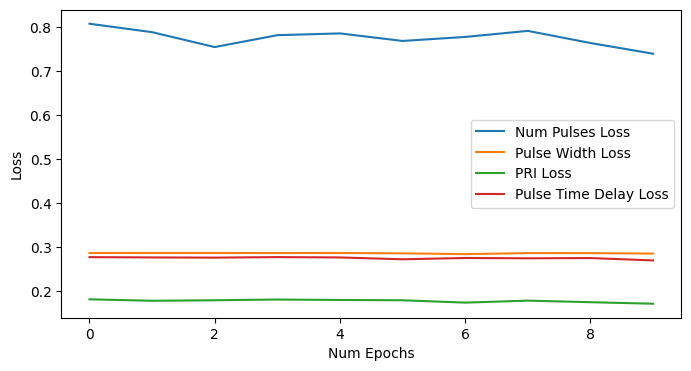

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

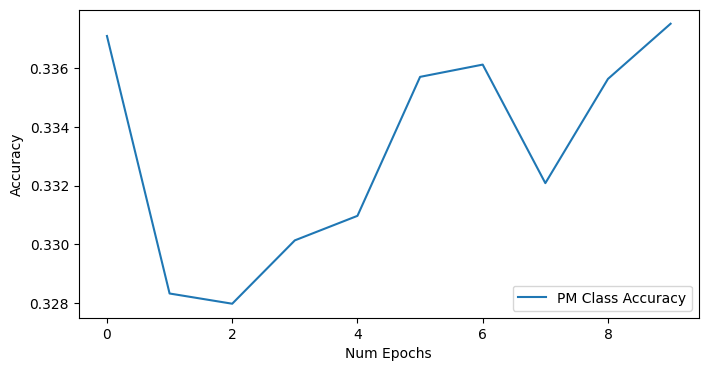

In [ ]:
plt.figure(figsize=[8, 4])
plt.plot(history.history['val_5_class_accuracy'], label="PM Class Accuracy")
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Without CSL Token [Archive]

In [ ]:
positional_emb = True
batch_size = 128
lr = 0.0005 # per reference
steps_per_epoch = X_train_std.shape[0] // batch_size
#steps_per_epoch = (X_train_std.shape[0] + batch_size - 1) // batch_size
num_epochs = 10

input_shape = (3000, 2) # X_train.shape

# Patch Dimensions
sequence_length = 3000                   # Sequence Length
patch_size = 60                         # patch size, how big is each "element" in our sequence? This should be a factor of the image size
                                        # 8 patches per reference once flattened
num_patches = (sequence_length // patch_size) ## number of patches, derived from the above two parameters
projection_dim = 768

## tranformer parameters
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding (was 768)
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [512]             # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer


# define patch creation as a layer (note that this layer has no learned parameters).

class PatchTokenizer(layers.Layer):
    # Initialise the layer.

    def __init__(
        self,
        patch_size,
        #kernel_size=3,
        #stride=1,
        #padding=1,
        #pooling_kernel_size=3,
        #pooling_stride=1,
        #num_conv_layers=1,
        # NOTE - tieing this to our projection_dim. Need to have the final output being the same as projection_dim
        #num_output_channels=[projection_dim // 2, 1], #1d output channel (LS edit)
        #positional_emb=positional_emb,
        projection_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim

        # Tokenizer
        self.conv1 = layers.Conv1D(projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid') # single convolutional layer. kernel size was patch_size
        self.flatten = layers.Reshape((-1, projection_dim))

        # # Add CLS (Classification) Token
        # self.cls_token = self.add_weight(
        #     name="cls_token",
        #     shape=(1, projection_dim),
        #     initializer = "zeros",
        #     trainable = True
        #     )

    def call(self, inputs):
        outputs = self.conv1(inputs) #extract patches
        outputs = self.flatten(outputs) #flatten patches into sequence
        #cls_tokens = tf.broadcast_to(self.cls_token, [tf.shape(outputs)[0], 1, self.projection_dim])
        #outputs = tf.concat([cls_tokens, outputs], axis=1)
        return outputs

class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        projection_dim,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.projection_dim = projection_dim
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        # feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="position_embeddings",
            shape=(self.sequence_length, self.projection_dim), #+1 for CLS token
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        position_embeddings = tf.broadcast_to(self.position_embeddings, [batch_size, self.sequence_length, self.projection_dim])
        return inputs + position_embeddings


# Create simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )

        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

def create_mtl_classifier(input_shape, patch_size):

    inputs = layers.Input(shape=input_shape, name='Raw IQ Data')

    ## CLS tokens concatenated to patch embedding per https://github.com/YuanGongND/ast/blob/master/src/models/ast_models.py#L165
    ## Entire embedding considered for classification

    # Create & Encode patches
    patches = PatchTokenizer(patch_size=patch_size, projection_dim=projection_dim)
    encoded_patches = patches(inputs) #tokenize data and create patches

    # Apply embedding
    position_embedding = PositionEmbedding(sequence_length=num_patches, projection_dim=projection_dim)
    encoded_patches = position_embedding(encoded_patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    embedding = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

#  # first classification branch - Number Pulses - regression
#     # class_1 = layers.Conv1D(64, 3, activation=None, padding='same')(embedding)
#     # class_1 = layers.BatchNormalization(axis=1)(class_1)
#     # class_1 = layers.Activation('relu')(class_1)
#     # class_1 = layers.Dropout(0.25)(class_1)
    class_1 = layers.Dense(32, activation='relu')(embedding)
    class_1 = layers.Dropout(0.5)(class_1)
    class_1 = layers.Dense(1, name='1_num_pulses')(class_1)

#     # second classification branch - Pulse Width - regression
#     # class_2 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_2 = layers.BatchNormalization(axis=1)(class_2)
#     # class_2 = layers.Activation('relu')(class_2)
#     # class_2 = layers.Dropout(0.25)(class_2)
    class_2 = layers.Dense(32, activation='relu')(embedding)
    class_2 = layers.Dropout(0.5)(class_2)
    class_2 = layers.Dense(1, name='2_pulse_width')(class_2)

#     # third classification problem - PRI - regression
#     # class_3 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_3 = layers.BatchNormalization(axis=1)(class_3)
#     # class_3 = layers.Activation('relu')(class_3)
#     # class_3 = layers.Dropout(0.25)(class_3)
    class_3 = layers.Dense(32, activation='relu')(embedding)
    class_3 = layers.Dropout(0.5)(class_3)
    class_3 = layers.Dense(1, name='3_PRI')(class_3)

#     # # # # # fourth classification problem - Pulse Time Delay - regression
#     # class_4 = layers.Conv1D(64, 3, activation='relu', padding='same')(embedding)
#     # class_4 = layers.BatchNormalization(axis=1)(class_4)
#     # class_4 = layers.Activation('relu')(class_4)
#     # class_4 = layers.Dropout(0.25)(class_4)
    class_4 = layers.Dense(32, activation='relu')(embedding)
    class_4 = layers.Dropout(0.5)(class_4)
    class_4 = layers.Dense(1, name='4_pulse_time_delay')(class_4)

   # fifth classification problem - Pulse Modulation Class - classification
    # class_5 = layers.BatchNormalization(axis=1)(class_5)
    # class_5 = layers.Activation('relu')(class_5)
    # class_5 = layers.Dropout(0.25)(class_5)
    class_5 = layers.Dense(32, activation='relu')(embedding)
    class_5 = layers.Dropout(0.5)(class_5)
    class_5 = layers.Dense(3, activation='softmax', name='5_class')(class_5) #sigmoid instead of softmax?

    # Classify outputs.
    MTL = ([class_1, class_2, class_3, class_4, class_5])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=MTL)

    return model

mtl_classifier_2 = create_mtl_classifier(input_shape, patch_size)


In [ ]:
print(mtl_classifier_2.summary())

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Raw IQ Data (InputLayer)  │ (None, 3000, 2)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_tokenizer_5         │ (None, 50, 768)        │         92,928 │ Raw IQ Data[0][0]      │
│ (PatchTokenizer)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_5      │ (None, 50, 768)        │         38,400 │ patch_tokenizer_5[0][… │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_9       │ (None, 50, 768)        │      9,450,240 │ position_embedding_5[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_10      │ (None, 50, 768)        │      9,450,240 │ transformer_block_9[0… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_11      │ (None, 50, 768)        │      9,450,240 │ transformer_block_10[… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_27    │ (None, 50, 768)        │          1,536 │ transformer_block_11[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 768)            │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 512)            │        393,728 │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_58 (Dropout)      │ (None, 512)            │              0 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 32)             │         16,416 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 32)             │         16,416 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 32)             │         16,416 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 32)             │         16,416 │ dropout_58[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 32)             │         16,416 │ dropout_58[0][0]       │
├──────────────────────

 Total params: 28,959,623 (110.47 MB)

 Trainable params: 28,959,623 (110.47 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
mtl_classifier_2.compile(optimizer=tf.keras.optimizers.Adam(), #learning_rate=lr
                     loss={
                         '1_num_pulses': 'mean_absolute_error',
                         '2_pulse_width': 'mean_absolute_error',
                         '3_PRI': 'mean_absolute_error',
                         '4_pulse_time_delay': 'mean_absolute_error',
                         '5_class': keras.losses.CategoricalCrossentropy(from_logits=False)
                     },
                      metrics={
                         '1_num_pulses': ['mean_absolute_error'],
                         '2_pulse_width': ['mean_absolute_error'],
                         '3_PRI': ['mean_absolute_error'],
                         '4_pulse_time_delay': ['mean_absolute_error'],
                         '5_class': ['accuracy']
                      }
                       #jit_compile=False
                       )

In [ ]:
history = mtl_classifier_2.fit(X_train_std,
                            [y_train_np, y_train_pw, y_train_pri, y_train_td, labels_class_train],
                            #steps_per_epoch=steps_per_epoch,
                            epochs=num_epochs,
                            validation_data=(X_val, [y_val_np, y_val_pw, y_val_pri, y_val_td, labels_class_val]),
                            # callbacks=[checkpoint_callback] #stop_early,
                            )

Epoch 1/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 257s 108ms/step - 1_num_pulses_mean_absolute_error: 0.9237 - 2_pulse_width_mean_absolute_error: 0.3619 - 3_PRI_mean_absolute_error: 0.2502 - 4_pulse_time_delay_mean_absolute_error: 0.3579 - 5_class_accuracy: 0.3338 - loss: 3.0252 - val_1_num_pulses_mean_absolute_error: 0.8067 - val_2_pulse_width_mean_absolute_error: 0.2871 - val_3_PRI_mean_absolute_error: 0.1816 - val_4_pulse_time_delay_mean_absolute_error: 0.2781 - val_5_class_accuracy: 0.3344 - val_loss: 2.6521
Epoch 2/10
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 222s 106ms/step - 1_num_pulses_mean_absolute_error: 0.8017 - 2_pulse_width_mean_absolute_error: 0.2828 - 3_PRI_mean_absolute_error: 0.1818 - 4_pulse_time_delay_mean_absolute_error: 0.2782 - 5_class_accuracy: 0.3317 - loss: 2.6438 - val_1_num_pulses_mean_absolute_error: 0.8111 - val_2_pulse_width_mean_absolute_error: 0.2868 - val_3_PRI_mean_absolute_error: 0.1815 - val_4_pulse_time_delay_mean_absolute_error: 0.2781 - val_5_class_accuracy: 0.3344

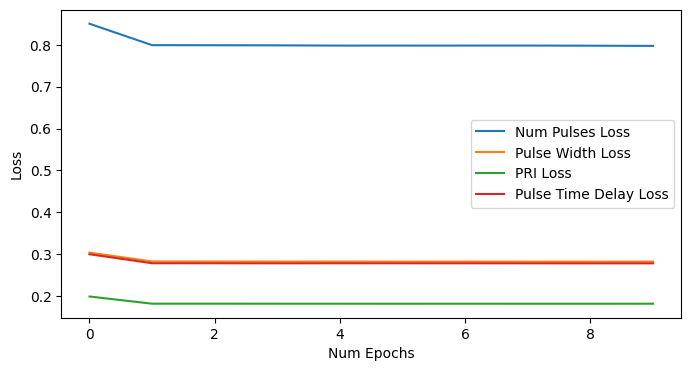

In [ ]:
plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()

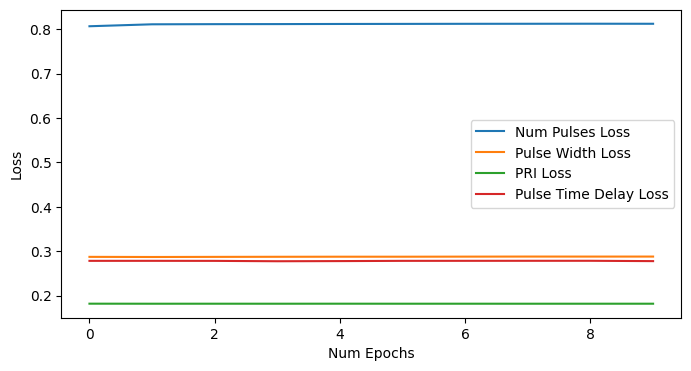

In [ ]:
## Evaluate model convergence

plt.figure(figsize=[8, 4])
#plt.plot(history.history['val_loss'], label="Total Validation Loss")
plt.plot(history.history['val_1_num_pulses_mean_absolute_error'], label="Num Pulses Loss")
plt.plot(history.history['val_2_pulse_width_mean_absolute_error'], label="Pulse Width Loss")
plt.plot(history.history['val_3_PRI_mean_absolute_error'], label="PRI Loss")
plt.plot(history.history['val_4_pulse_time_delay_mean_absolute_error'], label="Pulse Time Delay Loss")
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.legend()


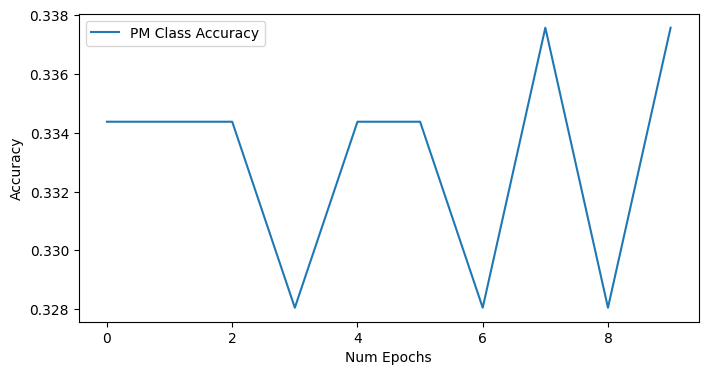

In [ ]:
plt.figure(figsize=[8, 4])
plt.plot(history.history['val_5_class_accuracy'], label="PM Class Accuracy")
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.legend()

**Investigation Outcome:** Retain CLS token - minor improvements in MAE across pri, num_pulses & time delay

# Evaluate Model [Archive]

In [ ]:
best_model = history.load_weights(checkpoint_file)

In [ ]:
# print('Time to predict test: %1.6f seconds' %(train_end - train_start))

In [ ]:
def eval_model(history, model):

    train_predictions = model.predict(X_train_std)
    test_predictions = model.predict(X_test_std)
    train_samples = len(X_train_std)
    test_samples = len(X_test_std)

    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Top-1 Accuracy (Training)")
    plt.plot(history.history["top-5-accuracy"], label="Top-5 Accuracy (Training)")
    plt.plot(history.history["val_accuracy"], label="Top-1 Accuracy (Validation)")
    plt.plot(history.history["val_top-5-accuracy"], label="Top-5 Accuracy (Validation)")
    plt.xlabel('Epoch')
    plt.ylabel('\% Accuracy')
    plt.legend()

    cmc_train = []
    cmc_test = []
    rank = []
    for i in range(1,101):
        cmc_train.append(100.0*np.sum(tf.math.in_top_k(y_train_pw[:,0], train_predictions, i))/train_samples)
        cmc_test.append(100.0*np.sum(tf.math.in_top_k(y_test_pw[:,0], test_predictions, i))/test_samples)
        rank.append(i)

    plt.figure(figsize=(10, 6))
    plt.plot(rank, cmc_train, label="Training Data")
    plt.plot(rank, cmc_test, label="Testing Data")
    plt.grid()
    plt.legend()
    plt.xlabel('% Accuracy')
    plt.ylabel('Rank')

In [ ]:
eval_model(history, best_model)

AttributeError: 'History' object has no attribute 'predict'

In [ ]:
print('X_train_std:', X_train_std.shape)
print('y_train_np:', y_train_np.shape)
print('y_train_pw:', y_train_pw.shape)
print('y_train_pri:', y_train_pri.shape)
print('y_train_td:', y_train_td.shape)
print('y_train_class:', y_train_class.shape)

print('X_test_std:', X_test_std.shape)
print('y_test_np:', y_test_np.shape)
print('y_test_pw:', y_test_pw.shape)
print('y_test_pri:', y_test_pri.shape)
print('y_test_td:', y_test_td.shape)
print('y_test_class:', y_test_class.shape)

X_train_std: (35000, 512, 2)
y_train_np: (35000,)
y_train_pw: (35000,)
y_train_pri: (35000,)
y_train_td: (35000,)
y_train_class: (35000,)
X_test_std: (15000, 512, 2)
y_test_np: (15000,)
y_test_pw: (15000,)
y_test_pri: (15000,)
y_test_td: (15000,)
y_test_class: (15000,)


#Archive

In [ ]:
# our transformer block -- Ref: Simon Denman 2022 QUT - CAB420
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

# our embedding generator
class TokenAndPositionEmbedding(layers.Layer):
    # create the embedding generator
    # params are:
    # - maxlen: maximum length of a sequence
    # - embed_dim: size of the embeddings to create
    # Note that both embedding layers will create the same size embeddings so they can be added
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # create the word token embedding layer
        # this looks a bit different to our lecture example. In the lecture, we used text (words), and so
        # we used an embedding layer to go from a word to a unique vector for each word. Here, we already
        # have numbers. But we want our numbers to the same size as the position embedding, so we can
        # use a dense layer to project to the same dimensionality, and then we can sum them up
        self.token_emb = layers.TimeDistributed(layers.Dense(embed_dim, activation=None))
        # create the position embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        # store sequence length, this is constant here
        self.maxlen = maxlen

    # call function, do a forward pass through the layer
    # params are:
    # - x: data to get embedding for
    def call(self, x):
        # get positions of the words in the sequence
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        # get the position embeddings
        positions = self.pos_emb(positions)
        # get the token/word embeddings
        x = self.token_emb(x)
        # return the sum of the two embeddings
        return x + positions

In [ ]:
## tranformer parameters
sequence_length = 512                   # Sequence Length
patch_size = 1                         # patch size, how big is each "element" in our sequence? This should be a factor of the image size
                                        # 8 patches per reference once flattened
num_patches = (sequence_length // patch_size) # ** 2 # number of patches, derived from the above two parameters
# the embedding size we'll use for our patches. Each of our patches will be projected into something
# of this size. A bigger value will mean a richer representation (but slower)
projection_dim = 768
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = projection_dim * 2  # size as the embedding
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [512, 256]             # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer

# small function to create a simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# patch encoder layer
class PatchEncoder(layers.Layer):
    # Initialise the layer. This will create the layers that will encode the patches.
    # Params are:
    # - num_patches: the number of patches we're processing
    # - projection_dim: the embedding size for each patch
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # create a dense layer to project the input with
        self.projection = layers.Dense(units=projection_dim)
        # create the position embedding
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Do a forward pass through the encoder
    # params are:
    # - patch: set of patches to process
    def call(self, patch):
        # get the positions of the patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # get the encoding, this will be the projection of the patches, pluse the position embedding
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# our transformer block
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )

        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training = None):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

# define patch creation as a layer (note that this layer has no learned parameters).
class Patches(layers.Layer):
    # Initialise the layer.
    # params are:
    # - patch_size: the size of the patch we wish to extract
    def __init__(self, patch_size):
        super(Patches, self).__init__() #Patches, self
        self.patch_size = patch_size

    # Do a forward pass through the layer
    # params are:
    # - images: what we want to split into patches
    def call(self, images):
        # input_shape = tf.shape(images)
        # get the batch size
        # batch_size = input_shape[0]
        #patch_dims = input_shape[-1]
        # height = input_shape[1]
        # width = input_shape[2]
        # channels = input_shape[3]

        images = tf.reshape(images, [8, 1, 128, 1]) #-1, input_shape[0], input_shape[1], 1

        # # num_patches_w = width // self.patch_size
        sizes=(1, self.patch_size, self.patch_size, 1)
        strides=(1, self.patch_size, self.patch_size, 1)

        patches = tf.image.extract_patches(
            images=images,
            sizes=sizes,
            strides=strides,
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        print("Shape of extracted patches:", patches.shape)  # Add this line to print the shape
        # package up the extracted patches in the correct shape
        batch_size = tf.shape(patches)[0]
        num_patches = tf.shape(patches)[1]
        patch_dims = tf.shape(patches)[2] * tf.shape(patches)[3]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

def create_mtl_classifier(input_shape, patch_size):
    inputs = layers.Input(shape=input_shape)

    # Flatten data.
    x = layers.Flatten(name='Flatten')(inputs)

    # Create patches.
    patches = Patches(patch_size)(x)
    num_patches = patches.shape[1]

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, transformer_units)(encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add the MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

mtl_classifier = create_mtl_classifier(input_shape, patch_size)
print(mtl_classifier.summary())

# Define Transformer Encoder & Patching [Archive]

In [ ]:
batch_size = 64 # per reference
# lr = 0.0005 # per reference
steps_per_epoch = X_train_std.shape[0] // batch_size
num_epochs = 10

input_shape = (512, 2) # X_train.shape

# Patch Dimensions
sequence_length = 512                   # Sequence Length
patch_size = 128                         # patch size, how big is each "element" in our sequence? This should be a factor of the image size
                                        # 8 patches per reference once flattened
#num_patches = (sequence_length // patch_size) # ** 2 # number of patches, derived from the above two parameters
# the embedding size we'll use for our patches. Each of our patches will be projected into something
# of this size. A bigger value will mean a richer representation (but slower)
projection_dim = 768

## tranformer parameters
num_heads = 3                           # number of attention heads
# size of the transfomer layer, note that there are two dense layers, the second of which is the same
transformer_units = 512 #projection_dim * 2  # size as the embedding
transformer_layers = 3                  # number of transformer layres
mlp_head_units = [512]             # size of the dense layers of classifier, i.e. after the transformers, prior to the final softmax layer
conv_layers = 0
positional_emb = True

# small function to create a simple MLP
def mlp(x, hidden_units, dropout_rate):
    # create dense layers, with a drop-out in between
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[512, 2],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (
                -1,
                tf.shape(outputs)[1] * tf.shape(outputs)[2],
                tf.shape(outputs)[-1],
            ),
        )
        return reshaped

class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = tf.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = tf.convert_to_tensor(self.position_embeddings)
        position_embeddings = tf.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return tf.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

def create_cct_model(
    image_size=sequence_length,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )


    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    # weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(5)(representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
cct_model = create_cct_model()


TypeError: 'int' object is not iterable